<a href="https://colab.research.google.com/github/Nithin3003/oops/blob/main/Document_from_Nithin_MS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 1: Import the zipfile module
import zipfile
import os

# Step 2: Define paths to your files on Google Drive
zip1 = "/content/drive/MyDrive/HAM10000_images_part_1.zip"
zip2 = "/content/drive/MyDrive/HAM10000_images_part_2.zip"

# Step 3: Create an output directory in Colab to extract the images
os.makedirs("/content/HAM10000_images", exist_ok=True)

# Step 4: Unzip part 1
with zipfile.ZipFile(zip1, 'r') as zip_ref:
    zip_ref.extractall("/content/HAM10000_images")

# Step 5: Unzip part 2
with zipfile.ZipFile(zip2, 'r') as zip_ref:
    zip_ref.extractall("/content/HAM10000_images")

print("✅ Successfully extracted both image zip files!")

✅ Successfully extracted both image zip files!


In [ ]:
import pandas as pd

metadata_path = "/content/drive/MyDrive/HAM10000_metadata.csv"
skin_df = pd.read_csv(metadata_path)
print(skin_df.head())


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [ ]:
import os
from glob import glob

image_folder = "/content/HAM10000_images"
image_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(image_folder, "*.jpg"))
}

skin_df['path'] = skin_df['image_id'].map(image_path_dict.get)
print(skin_df[['image_id', 'path']].head())


       image_id                                       path
0  ISIC_0027419  /content/HAM10000_images/ISIC_0027419.jpg
1  ISIC_0025030  /content/HAM10000_images/ISIC_0025030.jpg
2  ISIC_0026769  /content/HAM10000_images/ISIC_0026769.jpg
3  ISIC_0025661  /content/HAM10000_images/ISIC_0025661.jpg
4  ISIC_0031633  /content/HAM10000_images/ISIC_0031633.jpg


In [ ]:
from PIL import Image
import numpy as np

SIZE = 32  # Resize images to 32x32 to save memory

# Read and resize the images into numpy arrays
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE, SIZE))))

# Confirm with a few samples
print(skin_df[['image_id', 'dx', 'image']].head())

       image_id   dx                                              image
0  ISIC_0027419  bkl  [[[191, 152, 192], [194, 154, 193], [196, 152,...
1  ISIC_0025030  bkl  [[[24, 14, 29], [56, 39, 64], [106, 80, 112], ...
2  ISIC_0026769  bkl  [[[190, 136, 150], [199, 145, 161], [200, 141,...
3  ISIC_0025661  bkl  [[[35, 18, 28], [83, 51, 64], [128, 88, 103], ...
4  ISIC_0031633  bkl  [[[155, 110, 135], [188, 139, 168], [210, 157,...


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'dx' column to numerical labels
le = LabelEncoder()
skin_df['label'] = le.fit_transform(skin_df['dx'])

# Check the mapping
print(list(le.classes_))


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
from sklearn.utils import resample

# Separate each class
dfs = [skin_df[skin_df['label'] == i] for i in range(7)]

# Resample each class
n_samples = 500
balanced_dfs = [resample(df, replace=True, n_samples=n_samples, random_state=42) for df in dfs]

# Combine back into one DataFrame
skin_df_balanced = pd.concat(balanced_dfs)

# Shuffle the dataframe
skin_df_balanced = skin_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
print(skin_df_balanced['label'].value_counts())


label
3    500
4    500
0    500
2    500
5    500
6    500
1    500
Name: count, dtype: int64


In [ ]:
from tensorflow.keras.utils import to_categorical


# Image data
X = np.array(skin_df_balanced['image'].tolist()) / 255.0  # Normalize to 0-1

# Labels
Y = to_categorical(skin_df_balanced['label'], num_classes=7)


In [ ]:
from sklearn.model_selection import train_test_split

# Split for AutoKeras
x_train_auto, x_test_auto, y_train_auto, y_test_auto = train_test_split(X, Y, test_size=0.95, random_state=42)

# Optional: create a small validation set
x_unused, x_valid, y_unused, y_valid = train_test_split(x_test_auto, y_test_auto, test_size=0.05, random_state=42)


In [ ]:
!pip install autokeras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.5 MB/s eta 0:00:00


In [ ]:
import autokeras as ak


In [ ]:


# Define the classifier
clf = ak.ImageClassifier(
    max_trials=25,
    overwrite=True,
    project_name='skin_lesion_autokeras'
)

# Train
clf.fit(x_train_auto, y_train_auto, epochs=25)


Trial 25 Complete [00h 00m 11s]
val_loss: 0.7146690487861633

Best val_loss So Far: 0.66748046875
Total elapsed time: 00h 15m 56s
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 529ms/step - accuracy: 0.1256 - loss: 2.0231
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1882 - loss: 1.8904
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3108 - loss: 1.7971 
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3346 - loss: 1.6985 
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3823 - loss: 1.6231 
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4441 - loss: 1.5446 
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4765 - loss: 1.4532 
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5105 - loss: 1.3868 
Epoch 9/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5494 - loss: 1.3156 
Epoch 10/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5990 - loss: 1.2297
Epoch 11/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
# Evaluate on validation set
_, acc = clf.evaluate(x_valid, y_valid)
print("Accuracy = ", round(acc * 100, 2), "%")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.4593 - loss: 2.1501
Accuracy =  45.51 %


In [ ]:
# Get best model
model = clf.export_model()
model.summary()

# Save to drive (optional)
model.save('/content/drive/MyDrive/HAM10000/skin_lesion_model.h5')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast (Cast)                          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32 (CastToFloat32)      │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 3)           │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 256)         │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │         351,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 7)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 426,126 (1.63 MB)

 Trainable params: 426,119 (1.63 MB)

 Non-trainable params: 7 (32.00 B)

In [ ]:
# Evaluate accuracy on validation data
loss, accuracy = model.evaluate(x_valid, y_valid)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.4593 - loss: 2.1501
Validation Accuracy: 45.51%


In [ ]:
model.save('/content/drive/MyDrive/HAM10000/skin_lesion_model.keras')


In [ ]:
# Predict on validation images
preds = model.predict(x_valid)

# Convert probabilities to class indices
predicted_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(y_valid, axis=1)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 32, 32, 3))
  warnings.warn(msg)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes, target_names=le.classes_))


              precision    recall  f1-score   support

       akiec       0.60      0.09      0.16        33
         bcc       0.44      0.29      0.35        24
         bkl       0.25      0.38      0.30        21
          df       0.37      0.65      0.47        23
         mel       0.53      0.67      0.59        24
          nv       0.56      0.50      0.53        20
        vasc       0.68      0.77      0.72        22

    accuracy                           0.46       167
   macro avg       0.49      0.48      0.45       167
weighted avg       0.50      0.46      0.43       167



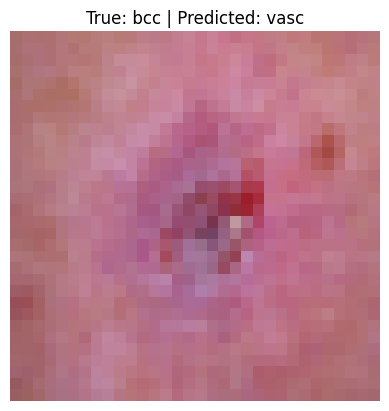

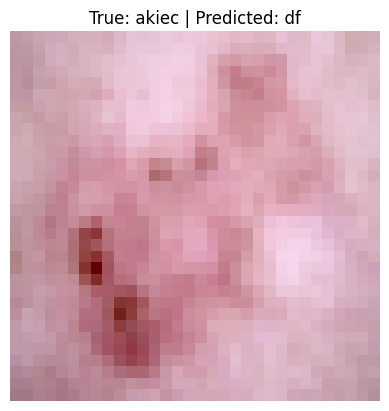

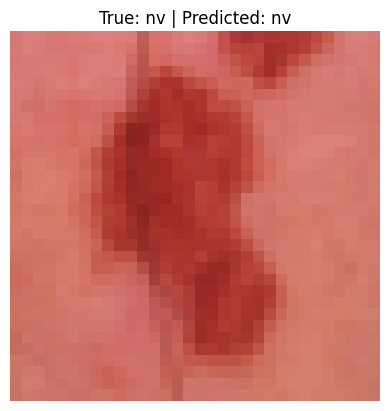

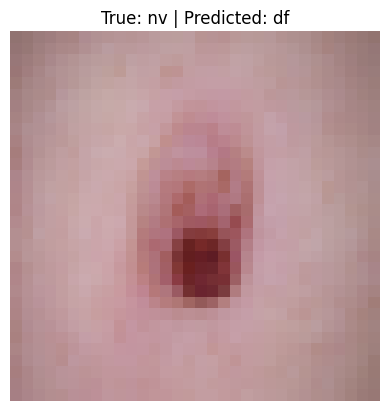

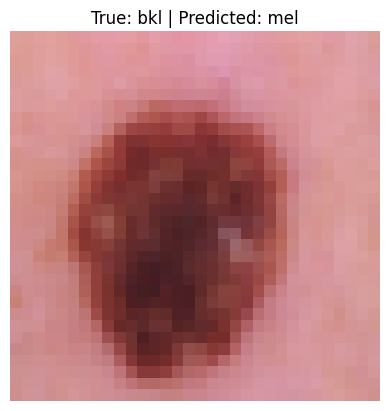

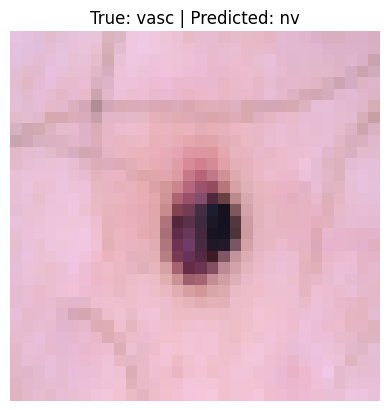

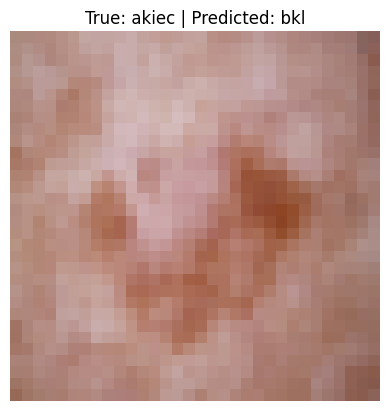

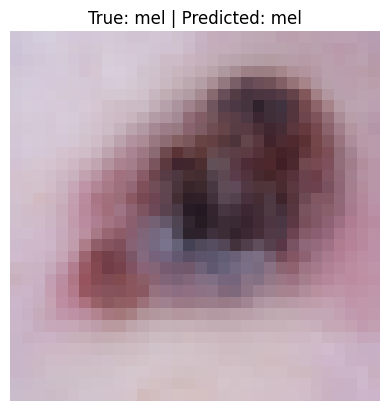

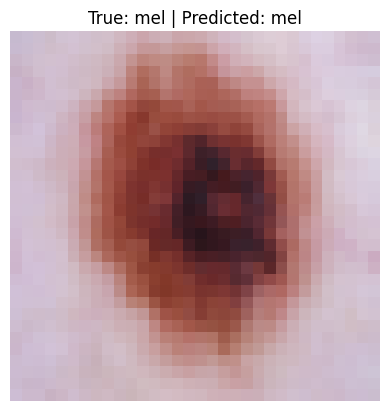

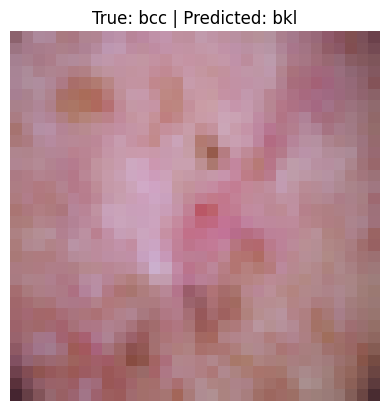

In [ ]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.imshow(x_valid[i])
    plt.title(f"True: {le.classes_[true_classes[i]]} | Predicted: {le.classes_[predicted_classes[i]]}")
    plt.axis('off')
    plt.show()


In [ ]:
# Evaluate model on validation/test set
loss, accuracy = model.evaluate(x_valid, y_valid)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy*100:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4593 - loss: 2.1501 
Validation Loss: 2.0365
Validation Accuracy: 45.51%


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

       akiec       0.60      0.09      0.16        33
         bcc       0.44      0.29      0.35        24
         bkl       0.25      0.38      0.30        21
          df       0.37      0.65      0.47        23
         mel       0.53      0.67      0.59        24
          nv       0.56      0.50      0.53        20
        vasc       0.68      0.77      0.72        22

    accuracy                           0.46       167
   macro avg       0.49      0.48      0.45       167
weighted avg       0.50      0.46      0.43       167



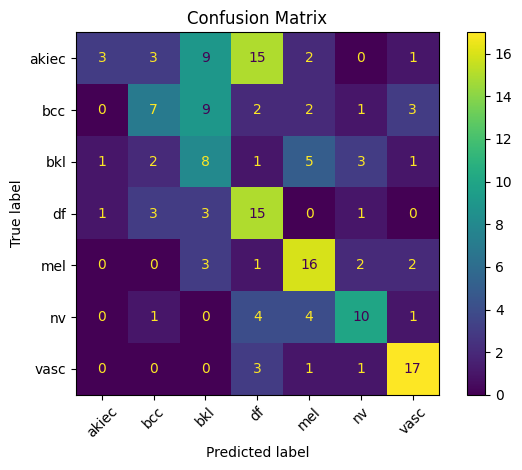

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predicted classes
y_pred_probs = model.predict(x_valid)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_valid, axis=1)

# Print report
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


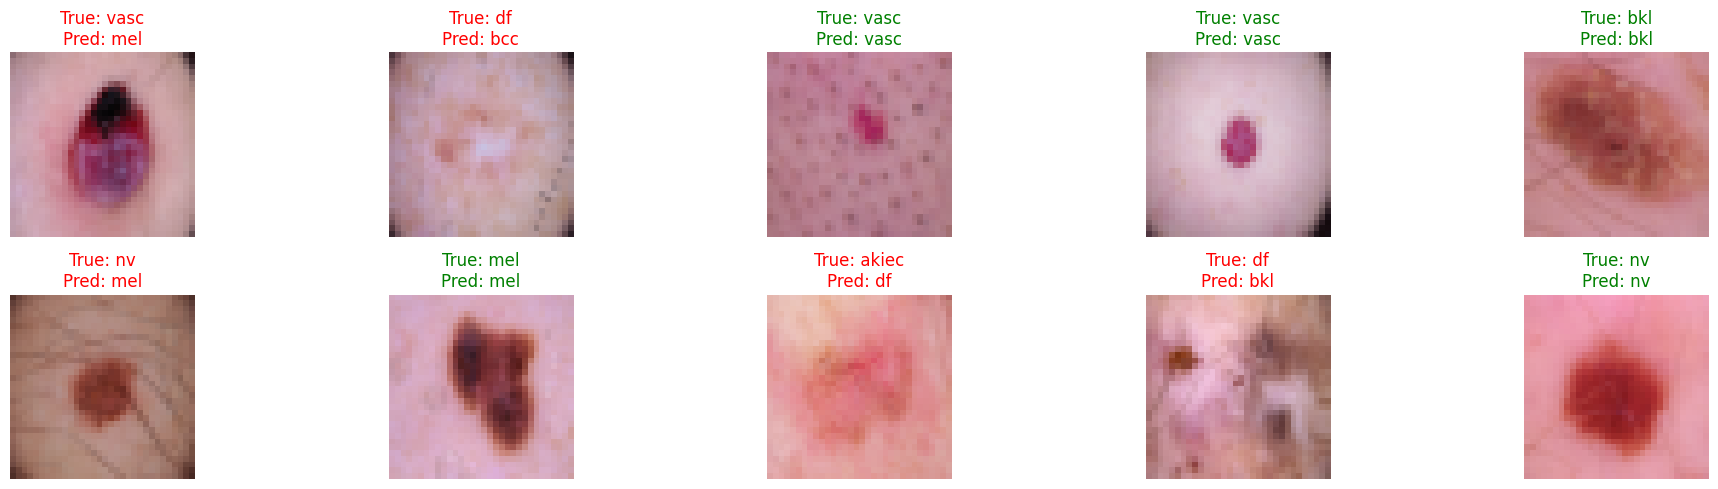

In [ ]:
import random

# Choose 10 random samples from validation set
num_samples = 10
indices = random.sample(range(len(x_valid)), num_samples)

plt.figure(figsize=(20, 5))
for i, idx in enumerate(indices):
    img = x_valid[idx]
    true_label = le.classes_[y_true[idx]]
    pred_label = le.classes_[y_pred[idx]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", color='green' if true_label == pred_label else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


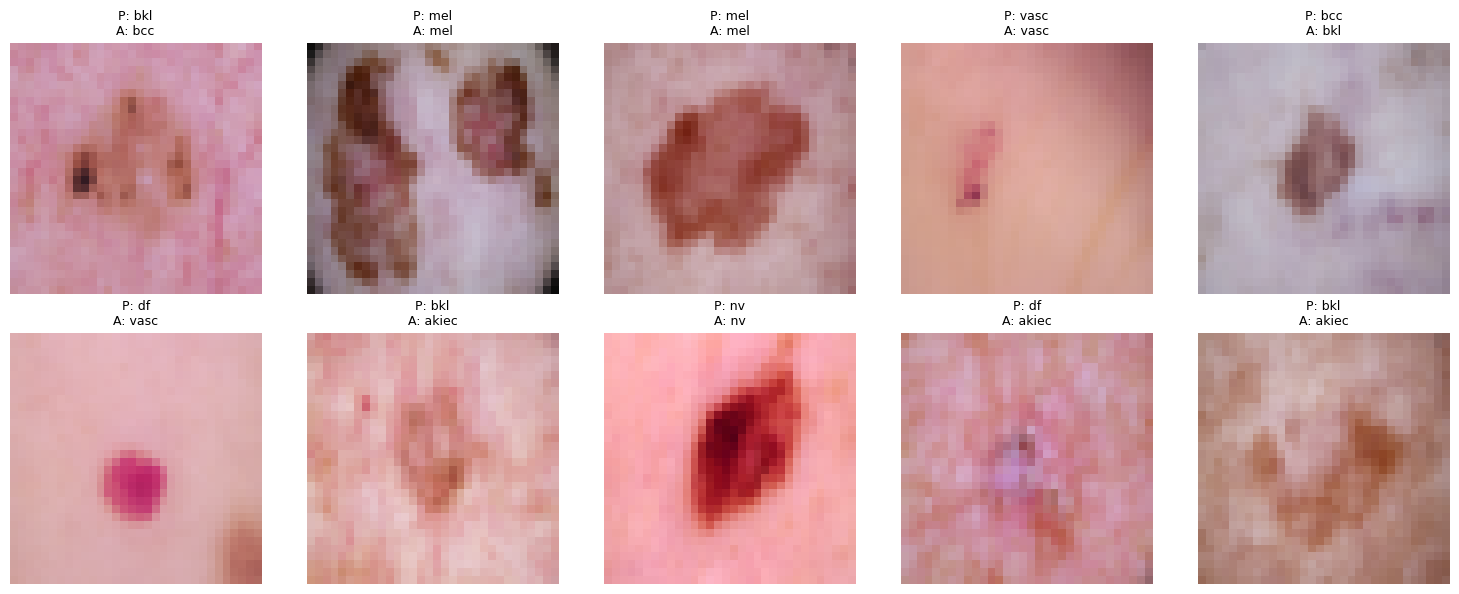

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Take 10 random test samples
indices = np.random.choice(len(x_test_auto), 10, replace=False)
sample_images = x_test_auto[indices]
true_labels = np.argmax(y_test_auto[indices], axis=1)

# Predict
preds = clf.predict(sample_images)
pred_labels = np.argmax(preds, axis=1) if preds.ndim > 1 else preds

# Plot all in a single row (or 2 rows of 5 for readability)
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"P: {le.classes_[pred_labels[i]]}\nA: {le.classes_[true_labels[i]]}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/HAM10000/skin_lesion_model.h5')


In [ ]:
np.save('/content/drive/MyDrive/HAM10000/x_train_auto.npy', x_train_auto)
np.save('/content/drive/MyDrive/HAM10000/y_train_auto.npy', y_train_auto)
np.save('/content/drive/MyDrive/HAM10000/x_test_auto.npy', x_test_auto)
np.save('/content/drive/MyDrive/HAM10000/y_test_auto.npy', y_test_auto)


In [ ]:
import pickle
with open('/content/drive/MyDrive/HAM10000/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)


In [ ]:
# Install AutoKeras
!pip install autokeras

# --- IMPORTS ---
import autokeras as ak
from tensorflow.keras.models import load_model
import numpy as np
import pickle

# --- LOAD MODEL (.keras format is safer for AutoKeras models) ---
model = load_model('/content/drive/MyDrive/HAM10000/skin_lesion_model.keras', custom_objects=ak.CUSTOM_OBJECTS)

# --- LOAD DATA ARRAYS ---
x_train_auto = np.load('/content/drive/MyDrive/HAM10000/x_train_auto.npy')
y_train_auto = np.load('/content/drive/MyDrive/HAM10000/y_train_auto.npy')
x_test_auto = np.load('/content/drive/MyDrive/HAM10000/x_test_auto.npy')
y_test_auto = np.load('/content/drive/MyDrive/HAM10000/y_test_auto.npy')

# --- LOAD LABEL ENCODER ---
with open('/content/drive/MyDrive/HAM10000/label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

print("✅ All files reloaded. You're ready to continue!")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ All files reloaded. You're ready to continue!


In [ ]:
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast (Cast)                          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32 (CastToFloat32)      │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 3)           │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 256)         │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │         351,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 7)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 852,247 (3.25 MB)

 Trainable params: 426,119 (1.63 MB)

 Non-trainable params: 7 (32.00 B)

 Optimizer params: 426,121 (1.63 MB)

In [ ]:
loss, accuracy = model.evaluate(x_test_auto, y_test_auto, verbose=0)
print(f"{accuracy * 100:.2f}%")


47.34%


In [ ]:
import os
import numpy as np
from PIL import Image

# --- Paths to your original image arrays ---
x_train_orig = np.load('/content/drive/MyDrive/HAM10000/x_train_auto.npy')
x_test_orig = np.load('/content/drive/MyDrive/HAM10000/x_test_auto.npy')

# --- Resize function ---
def resize_images(images, size=(224, 224)):
    resized = []
    for img in images:
        img_pil = Image.fromarray(img.astype('uint8'))
        img_resized = img_pil.resize(size)
        resized.append(np.array(img_resized))
    return np.array(resized)

# --- Resize ---
x_train_resized = resize_images(x_train_orig)
x_test_resized = resize_images(x_test_orig)

# --- Save to .npy files ---
np.save('/content/drive/MyDrive/HAM10000/x_train_resized.npy', x_train_resized)
np.save('/content/drive/MyDrive/HAM10000/x_test_resized.npy', x_test_resized)

print("✅ Resized images saved!")


✅ Resized images saved!


In [ ]:
# --- Imports ---
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- STEP 1: Load resized image arrays ---
x_train = np.load('/content/drive/MyDrive/HAM10000/x_train_resized.npy')  # Shape: (175, 224, 224, 3)
x_test = np.load('/content/drive/MyDrive/HAM10000/x_test_resized.npy')    # Shape: (3325, 224, 224, 3)

# --- STEP 2: Load already one-hot encoded labels ---
y_train_cat = np.load('/content/drive/MyDrive/HAM10000/y_train_auto.npy')  # Shape: (175, 7)
y_test_cat = np.load('/content/drive/MyDrive/HAM10000/y_test_auto.npy')    # Shape: (3325, 7)

# --- STEP 3: Sanity check ---
print("✅ Final check:")
print("x_train shape:", x_train.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("x_test shape:", x_test.shape)
print("y_test_cat shape:", y_test_cat.shape)

# --- STEP 4: Build AlexNet model ---
alexnet_model = Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(256, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 classes
])

# --- STEP 5: Compile the model ---
alexnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- STEP 6: Train the model ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_alexnet = alexnet_model.fit(
    x_train, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_data=(x_test, y_test_cat),
    callbacks=[early_stop]
)

print("✅ AlexNet training complete!")


✅ Final check:
x_train shape: (175, 224, 224, 3)
y_train_cat shape: (175, 7)
x_test shape: (3325, 224, 224, 3)
y_test_cat shape: (3325, 7)
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.1096 - loss: 1.9459 - val_accuracy: 0.1432 - val_loss: 1.9458
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - accuracy: 0.1892 - loss: 1.9449 - val_accuracy: 0.1411 - val_loss: 1.9459
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.1790 - loss: 1.9432 - val_accuracy: 0.1405 - val_loss: 1.9476
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 558ms/step - accuracy: 0.2056 - loss: 1.9366 - val_accuracy: 0.1405 - val_loss: 1.9665
✅ AlexNet training complete!


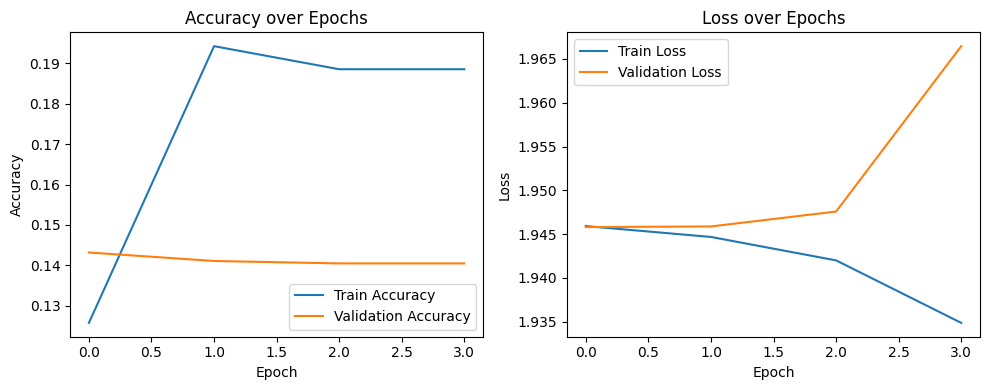

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_alexnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_alexnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_alexnet.history['loss'], label='Train Loss')
plt.plot(history_alexnet.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
loss, accuracy = alexnet_model.evaluate(x_test, y_test_cat)
print(f"🔍 Final Test Accuracy: {accuracy:.4f}")
print(f"📉 Final Test Loss: {loss:.4f}")


104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1491 - loss: 1.9458
🔍 Final Test Accuracy: 0.1432
📉 Final Test Loss: 1.9458


In [ ]:
# --- Evaluate AlexNet ---
alexnet_scores = alexnet_model.evaluate(x_test, y_test_cat, verbose=1)
print(f"📊 AlexNet Test Accuracy: {alexnet_scores[1]*100:.2f}%")

# --- Save AlexNet again (if needed) ---
alexnet_model.save('/content/drive/MyDrive/HAM10000/alexnet_model.h5')
print("💾 AlexNet model saved!")


104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1491 - loss: 1.9458


📊 AlexNet Test Accuracy: 14.32%
💾 AlexNet model saved!


In [ ]:
# --- Imports ---
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# --- Load data ---
x_train = np.load('/content/drive/MyDrive/HAM10000/x_train_resized.npy')  # shape: (175, 224, 224, 3)
x_test = np.load('/content/drive/MyDrive/HAM10000/x_test_resized.npy')    # shape: (3325, 224, 224, 3)
y_train = np.load('/content/drive/MyDrive/HAM10000/y_train_auto.npy')     # shape: (175,)
y_test = np.load('/content/drive/MyDrive/HAM10000/y_test_auto.npy')       # shape: (3325,)

# --- Sanity check ---
print("Shapes before encoding:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

# --- Use existing one-hot encoded labels ---
y_train_cat = y_train
y_test_cat = y_test



# --- Build ResNet50 model ---
input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)

resnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- Train ---
history_resnet = resnet_model.fit(
    x_train, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_data=(x_test, y_test_cat),
    callbacks=[early_stop]
)

print("✅ ResNet50 training complete!")


Shapes before encoding:
x_train: (175, 224, 224, 3)
y_train: (175, 7)
x_test: (3325, 224, 224, 3)
y_test: (3325, 7)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_823']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.2033 - loss: 2.1357 - val_accuracy: 0.1405 - val_loss: 1.9965
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.1280 - loss: 2.1654 - val_accuracy: 0.1417 - val_loss: 2.0104
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.1331 - loss: 2.1164 - val_accuracy: 0.1408 - val_loss: 1.9835
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2380 - loss: 1.9256 - val_accuracy: 0.1405 - val_loss: 1.9816
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.1463 - loss: 2.1118 - val_accuracy: 0.1408 - val_loss: 1.9767
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2028 - loss: 2.0156 - val_accuracy: 0.1408 - val_loss: 1.9733
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2286 - loss: 1.9979 - val_accuracy: 0.1408 - val_loss: 1.9773
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.1439 - loss: 2.0553 - val_accuracy: 0.1408 - val_loss: 1.9879
Epoch 9/20
6/6 ━━━━

In [ ]:
# --- Evaluate ResNet50 ---
resnet_scores = resnet_model.evaluate(x_test, y_test_cat, verbose=1)
print(f"📊 ResNet50 Test Accuracy: {resnet_scores[1]*100:.2f}%")

# --- Save ResNet50 again (if needed) ---
resnet_model.save('/content/drive/MyDrive/HAM10000/resnet50_model.h5')
print("💾 ResNet50 model saved!")


104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.1361 - loss: 1.9754


📊 ResNet50 Test Accuracy: 14.08%
💾 ResNet50 model saved!


In [ ]:
import os

base_dir = '/content/drive/MyDrive/HAM10000'

# List folders
print("Subfolders (classes):", os.listdir(base_dir))

# Count images inside each class folder
for folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, folder)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
        print(f"{folder}: {num_images} images")


Subfolders (classes): ['skin_lesion_model.keras', 'skin_lesion_model.h5', 'x_train_auto.npy', 'y_train_auto.npy', 'x_test_auto.npy', 'y_test_auto.npy', 'label_encoder.pkl', 'x_train_resized.npy', 'x_test_resized.npy', 'alexnet_model.h5', 'resnet50_model.h5']


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

# --- Load preprocessed data ---
x_train = np.load('/content/drive/MyDrive/HAM10000/x_train_resized.npy')
x_test = np.load('/content/drive/MyDrive/HAM10000/x_test_resized.npy')
y_train = np.load('/content/drive/MyDrive/HAM10000/y_train_auto.npy', allow_pickle=True)
y_test = np.load('/content/drive/MyDrive/HAM10000/y_test_auto.npy', allow_pickle=True)

# --- Combine all data ---
x_full = np.concatenate([x_train, x_test])
y_full = np.concatenate([y_train, y_test])

# --- Convert one-hot to class labels ---
y_labels = np.argmax(y_full, axis=1)

# --- Stratified split based on class labels ---
x_train, x_test, y_train_lbl, y_test_lbl = train_test_split(
    x_full, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

# --- One-hot encode after split ---
y_train = to_categorical(y_train_lbl)
y_test = to_categorical(y_test_lbl)

# --- Save label encoder (for class names reference) ---
le = LabelEncoder()
le.fit(y_labels)
with open('/content/drive/MyDrive/HAM10000/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print(f"✅ x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"✅ x_test: {x_test.shape}, y_test: {y_test.shape}")

# --- Data augmentation ---
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
train_gen = datagen.flow(x_train, y_train, batch_size=32)

# --- Model setup ---
input_tensor = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)

# ✅ Fine-tune EfficientNet: unfreeze last 50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

efficientnet_model = Model(inputs=base_model.input, outputs=output)
efficientnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# --- Train ---
history = efficientnet_model.fit(
    train_gen,
    epochs=20,
    validation_data=(x_test, y_test)
)

# --- Evaluate ---
loss, acc = efficientnet_model.evaluate(x_test, y_test)
print(f"📊 EfficientNetB0 Test Accuracy: {acc*100:.2f}%")

# --- Save model ---
efficientnet_model.save('/content/drive/MyDrive/HAM10000/efficientnet_model.h5')
print("✅ Model saved as efficientnet_model.h5")


✅ x_train: (2800, 224, 224, 3), y_train: (2800, 7)
✅ x_test: (700, 224, 224, 3), y_test: (700, 7)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_960']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


88/88 ━━━━━━━━━━━━━━━━━━━━ 94s 693ms/step - accuracy: 0.1202 - loss: 1.9892 - val_accuracy: 0.1429 - val_loss: 1.9649
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 377ms/step - accuracy: 0.1521 - loss: 1.9628 - val_accuracy: 0.1429 - val_loss: 1.9608
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 369ms/step - accuracy: 0.1434 - loss: 1.9592 - val_accuracy: 0.1429 - val_loss: 1.9506
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 373ms/step - accuracy: 0.1382 - loss: 1.9551 - val_accuracy: 0.1429 - val_loss: 1.9476
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 31s 356ms/step - accuracy: 0.1394 - loss: 1.9522 - val_accuracy: 0.1429 - val_loss: 1.9480
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 362ms/step - accuracy: 0.1595 - loss: 1.9458 - val_accuracy: 0.1429 - val_loss: 1.9525
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 366ms/step - accuracy: 0.1488 - loss: 1.9488 - val_accuracy: 0.1429 - val_loss: 1.9489
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 362ms/step - accuracy: 0.1295 - loss: 1.9524 - val_accuracy: 0.142

📊 EfficientNetB0 Test Accuracy: 14.29%
✅ Model saved as efficientnet_model.h5


In [ ]:
import tensorflow as tf
tf.saved_model.save(efficientnet_model, '/content/drive/MyDrive/HAM10000/efficientnet_model')


In [ ]:
loaded_model = tf.saved_model.load('/content/drive/MyDrive/HAM10000/efficientnet_model')


In [ ]:
import os

# Verify if all models are saved in the correct directory
model_directory = '/content/drive/MyDrive/HAM10000/'
model_files = os.listdir(model_directory)
print("Saved models:", model_files)


Saved models: ['skin_lesion_model.keras', 'skin_lesion_model.h5', 'x_train_auto.npy', 'y_train_auto.npy', 'x_test_auto.npy', 'y_test_auto.npy', 'label_encoder.pkl', 'x_train_resized.npy', 'x_test_resized.npy', 'alexnet_model.h5', 'resnet50_model.h5', 'efficientnet_model.h5']


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import autokeras as ak

# --- Load AutoKeras Model ---
try:
    with tf.keras.utils.custom_object_scope(ak.CUSTOM_OBJECTS):
        auto_model = load_model('/content/drive/MyDrive/HAM10000/skin_lesion_model.keras')
    print("AutoKeras model loaded successfully.")
except Exception as e:
    print(f"Error loading AutoKeras model: {e}")

# --- Load AlexNet Model ---
try:
    alexnet_model = load_model('/content/drive/MyDrive/HAM10000/alexnet_model.h5')
    print("AlexNet model loaded successfully.")
except Exception as e:
    print(f"Error loading AlexNet model: {e}")

# --- Load ResNet50 Model ---
try:
    resnet_model = load_model('/content/drive/MyDrive/HAM10000/resnet50_model.h5')
    print("ResNet50 model loaded successfully.")
except Exception as e:
    print(f"Error loading ResNet50 model: {e}")

# --- Load EfficientNet Model ---
try:
    efficientnet_model = load_model('/content/drive/MyDrive/HAM10000/efficientnet_model.h5')
    print("EfficientNet model loaded successfully.")
except Exception as e:
    print(f"Error loading EfficientNet model: {e}")


AutoKeras model loaded successfully.


AlexNet model loaded successfully.


ResNet50 model loaded successfully.


EfficientNet model loaded successfully.


In [ ]:
# --- Print Concise Model Information ---

def print_model_info(model, model_name):
    if model:
        print(f"{model_name} Model:")
        # Print input shape, output shape, and total parameters
        print(f"Input Shape: {model.input_shape}")
        print(f"Output Shape: {model.output_shape}")
        print(f"Total Parameters: {model.count_params()}")
        print("-" * 30)

# --- Apply to each model ---
print_model_info(auto_model, "AutoKeras")
print_model_info(alexnet_model, "AlexNet")
print_model_info(resnet_model, "ResNet50")
print_model_info(efficientnet_model, "EfficientNet")


AutoKeras Model:
Input Shape: (None, 32, 32, 3)
Output Shape: (None, 7)
Total Parameters: 426126
------------------------------
AlexNet Model:
Input Shape: (None, 224, 224, 3)
Output Shape: (None, 7)
Total Parameters: 46775687
------------------------------
ResNet50 Model:
Input Shape: (None, 224, 224, 3)
Output Shape: (None, 7)
Total Parameters: 25693063
------------------------------
EfficientNet Model:
Input Shape: (None, 224, 224, 3)
Output Shape: (None, 7)
Total Parameters: 4214442
------------------------------


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/HAM10000_metadata.csv')
print(df.head())  # Display the first few rows to check the data


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [ ]:
import os

# List all files and directories in the specified path
path = '/content/drive/MyDrive/HAM10000'
print(os.listdir(path))


['skin_lesion_model.keras', 'skin_lesion_model.h5', 'x_train_auto.npy', 'y_train_auto.npy', 'x_test_auto.npy', 'y_test_auto.npy', 'label_encoder.pkl', 'x_train_resized.npy', 'x_test_resized.npy', 'alexnet_model.h5', 'resnet50_model.h5', 'efficientnet_model.h5']


In [ ]:
!pip install scikit-image


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from skimage.transform import resize

# Load the models
auto_model = tf.keras.models.load_model('/content/drive/MyDrive/HAM10000/skin_lesion_model.keras')
alexnet_model = tf.keras.models.load_model('/content/drive/MyDrive/HAM10000/alexnet_model.h5')
resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/HAM10000/resnet50_model.h5')
efficientnet_model = tf.keras.models.load_model('/content/drive/MyDrive/HAM10000/efficientnet_model.h5')

# Load the test data
x_test = np.load('/content/drive/MyDrive/HAM10000/x_test_resized.npy')  # Example path
y_test_auto = np.load('/content/drive/MyDrive/HAM10000/y_test_auto.npy')  # Corrected path to match available data

# Resize the test data for AutoKeras model (32x32)
x_test_auto = np.array([resize(img, (32, 32), preserve_range=True).astype(np.uint8) for img in x_test])

# Resize the test data for other models (224x224) - AlexNet, ResNet50, EfficientNet
x_test_224 = np.array([resize(img, (224, 224), preserve_range=True).astype(np.uint8) for img in x_test])

# Create an empty list to store results
results = []

# Evaluate each model and append the results
models = [auto_model, alexnet_model, resnet_model, efficientnet_model]
model_names = ["AutoKeras", "AlexNet", "ResNet50", "EfficientNet"]
test_data = [x_test_auto, x_test_224, x_test_224, x_test_224]  # Use resized data for each model

for model, name, test_images in zip(models, model_names, test_data):
    test_loss, test_acc = model.evaluate(test_images, y_test_auto, verbose=0)
    results.append({"Model": name, "Test Accuracy": test_acc, "Test Loss": test_loss})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


          Model  Test Accuracy  Test Loss
0     AutoKeras       0.142556   7.361265
1       AlexNet       0.143158   1.945797
2      ResNet50       0.140752   1.973315
3  EfficientNet       0.140752   1.945921


In [ ]:
auto_model.save('/content/drive/MyDrive/HAM10000/auto_model.h5')
alexnet_model.save('/content/drive/MyDrive/HAM10000/alexnet_model.h5')
resnet_model.save('/content/drive/MyDrive/HAM10000/resnet50_model.h5')


In [ ]:
x_train_auto = np.load('/content/drive/MyDrive/HAM10000/x_train_auto.npy')
y_train_auto = np.load('/content/drive/MyDrive/HAM10000/y_train_auto.npy')
x_test_auto = np.load('/content/drive/MyDrive/HAM10000/x_test_auto.npy')
y_test_auto = np.load('/content/drive/MyDrive/HAM10000/y_test_auto.npy')


In [ ]:
import joblib
joblib.dump(le, '/content/drive/MyDrive/HAM10000/label_encoder.pkl')


['/content/drive/MyDrive/HAM10000/label_encoder.pkl']

In [ ]:
with open('/content/drive/MyDrive/HAM10000/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
import zipfile
import os

# Paths
zip1 = "/content/drive/MyDrive/HAM10000_images_part_1.zip"
zip2 = "/content/drive/MyDrive/HAM10000_images_part_2.zip"
output_dir = "/content/drive/MyDrive/HAM10000/all_images"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Unzip function
def unzip_to_folder(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzip both parts
unzip_to_folder(zip1, output_dir)
unzip_to_folder(zip2, output_dir)

print("✅ Both zip files extracted to 'all_images'")


✅ Both zip files extracted to 'all_images'


In [ ]:
import os
import shutil
import pandas as pd

# Paths
metadata_path = "/content/drive/MyDrive/HAM10000_metadata.csv"
all_images_path = "/content/drive/MyDrive/HAM10000/all_images"
organized_path = "/content/drive/MyDrive/HAM10000/images"

# Load metadata
df = pd.read_csv(metadata_path)

# Count before organizing
already_present = 0
moved = 0
missing_files = []

# Organize images
for index, row in df.iterrows():
    img_name = row['image_id'] + ".jpg"
    label = row['dx']
    src = os.path.join(all_images_path, img_name)
    dest_dir = os.path.join(organized_path, label)
    dest = os.path.join(dest_dir, img_name)

    os.makedirs(dest_dir, exist_ok=True)

    if os.path.exists(dest):
        already_present += 1
        continue

    if os.path.exists(src):
        shutil.copy(src, dest)
        moved += 1
    else:
        missing_files.append(src)

# Report
print(f"✅ Done organizing.")
print(f"✔️ Moved {moved} new images.")
print(f"📁 Already in place: {already_present} images.")
if missing_files:
    print(f"❌ Missing {len(missing_files)} files:")
    for file in missing_files:
        print(f" - {file}")
else:
    print("🚫 No missing images.")


✅ Done organizing.
✔️ Moved 10015 new images.
📁 Already in place: 0 images.
🚫 No missing images.


In [ ]:
import shutil

shutil.rmtree('/content/drive/MyDrive/HAM10000/all_images')
print("✅ Deleted 'all_images' folder successfully!")


✅ Deleted 'all_images' folder successfully!


In [ ]:
import pandas as pd
import os

data_dir = "/content/drive/MyDrive/HAM10000/images"
csv_path = "/content/drive/MyDrive/HAM10000_metadata.csv"

df = pd.read_csv(csv_path)

# Label mapping
label_names = df['dx'].unique()
label_to_index = {name: idx for idx, name in enumerate(label_names)}
df['label'] = df['dx'].map(label_to_index)

# Construct correct path for image in class folder
df['image_path'] = df.apply(lambda row: os.path.join(data_dir, row['dx'], f"{row['image_id']}.jpg"), axis=1)

# Filter out missing images
df = df[df['image_path'].apply(os.path.exists)]

print("✅ Images found:", len(df))


✅ Images found: 10015


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

print("Train size:", len(train_df))
print("Test size:", len(test_df))


Train size: 8012
Test size: 2003


In [ ]:
import tensorflow as tf

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Function to load and preprocess image
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

# Data augmentation for training
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# Convert pandas dataframe to tf.data.Dataset
def df_to_dataset(dataframe, shuffle=True, augment=False):
    paths = dataframe['image_path'].values
    labels = dataframe['label'].values
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create training and test datasets
train_ds = df_to_dataset(train_df, shuffle=True, augment=True)
test_ds = df_to_dataset(test_df, shuffle=False, augment=False)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, callbacks

# Number of classes
num_classes = df['label'].nunique()

# Load EfficientNetB0 base (without top layer)
base_model = EfficientNetB0(input_shape=(224, 224, 3),
                             include_top=False,
                             weights='imagenet')
base_model.trainable = False  # Freeze base model

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_cb = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')
earlystop_cb = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Train
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=25,
    callbacks=[checkpoint_cb, earlystop_cb]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3858 - loss: 1.8547

251/251 ━━━━━━━━━━━━━━━━━━━━ 2037s 2s/step - accuracy: 0.3864 - loss: 1.8534 - val_accuracy: 0.6695 - val_loss: 1.2096
Epoch 2/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 120s 95ms/step - accuracy: 0.6590 - loss: 1.2262 - val_accuracy: 0.6695 - val_loss: 1.1480
Epoch 3/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 149s 118ms/step - accuracy: 0.6647 - loss: 1.1928 - val_accuracy: 0.6695 - val_loss: 1.1407
Epoch 4/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 139s 118ms/step - accuracy: 0.6785 - loss: 1.1505 - val_accuracy: 0.6695 - val_loss: 1.1322
Epoch 5/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - accuracy: 0.6678 - loss: 1.1544 - val_accuracy: 0.6695 - val_loss: 1.5345
Epoch 6/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 88s 118ms/step - accuracy: 0.6648 - loss: 1.1689 - val_accuracy: 0.6695 - val_loss: 1.1308
Epoch 7/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 85s 98ms/step - accuracy: 0.6739 - loss: 1.1401 - val_accuracy: 0.6695 - val_loss: 1.2705
Epoch 8/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 180s 100ms/step - accuracy: 0.6673 - loss: 1.1576 - val

In [ ]:
import os

# Search for the saved model in your Drive
!find /content/drive/MyDrive -name "best_model.h5"


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import load_model
import os

# Updated path (adjust this after step 1)
dataset_dir = "/content/drive/MyDrive/HAM10000/images"

# Load dataset with validation split
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Checkpoint and final model paths
checkpoint_path = "/content/drive/MyDrive/HAM10000/best_model.keras"
final_model_path = "/content/drive/MyDrive/HAM10000/final_model.keras"

# Load previous model if available
try:
    model = load_model(checkpoint_path)
    print("✅ Loaded model from checkpoint.")
except:
    print("⚠️ No previous checkpoint found. Creating new model...")

    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(7, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

# Callbacks
checkpoint_cb = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
earlystop_cb = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# Save final model
model.save(final_model_path)
print(f"✅ Final model saved to: {final_model_path}")


Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.
⚠️ No previous checkpoint found. Creating new model...
Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 133s 422ms/step - accuracy: 0.6369 - loss: 1.0486 - val_accuracy: 0.7259 - val_loss: 0.7317
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 305ms/step - accuracy: 0.7194 - loss: 0.7609 - val_accuracy: 0.7389 - val_loss: 0.6785
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 304ms/step - accuracy: 0.7457 - loss: 0.6926 - val_accuracy: 0.7604 - val_loss: 0.6441
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 75s 277ms/step - accuracy: 0.7523 - loss: 0.6663 - val_accuracy: 0.7778 - val_loss: 0.6216
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 105s 369ms/step - accuracy: 0.7642 - loss: 0.6408 - val_accuracy: 0.7678 - val_loss: 0.6196
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 303ms/step - accuracy: 0.7592 - loss: 0.6333 - val_accuracy: 0.7798 - val_loss: 0.6025
Epoch 7/1

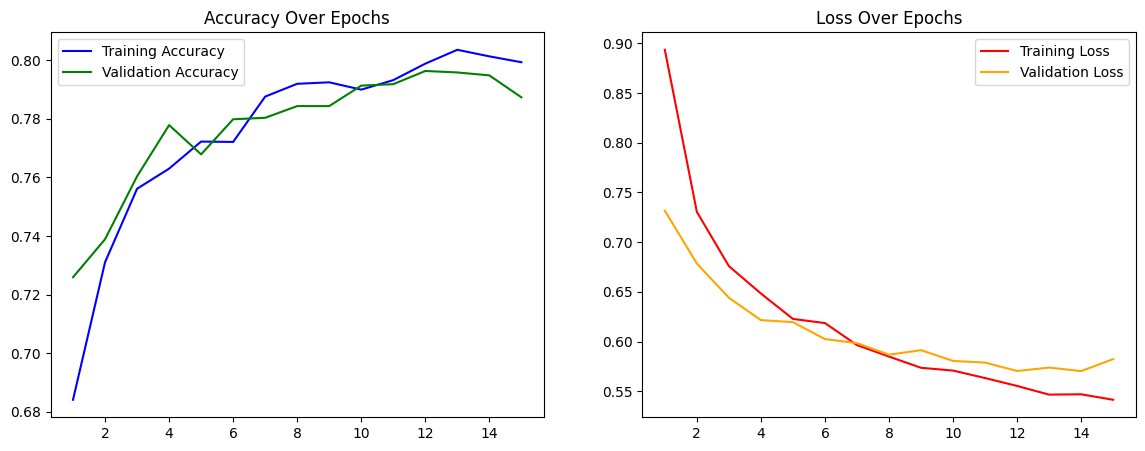

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()


In [ ]:
# Correct path to the image folder containing class subfolders
temp_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/HAM10000",  # <- no '/train'
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']



Found 10015 files belonging to 2 classes.


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load your test image
img_path = "/content/drive/MyDrive/HAM10000/images/akiec/ISIC_0025182.jpg"  # change this to your image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# Predict
pred = model.predict(img_array)
pred_class = np.argmax(pred)

# Map prediction to class label
predicted_label = class_names[pred_class]
print("✅ Predicted class:", predicted_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
✅ Predicted class: nv


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


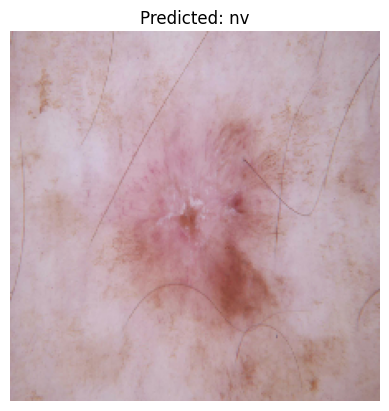

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Path to image you want to test
img_path = "/content/drive/MyDrive/HAM10000/images/akiec/ISIC_0025182.jpg"  # Replace with your test image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

# Predict
pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]

# Class mapping (update this to match your actual folder/class names)
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
predicted_label = class_names[pred_class]

# Show result
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


In [ ]:
# Evaluate the model on validation dataset
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"\n✅ Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"📉 Validation Loss: {val_loss:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.8072 - loss: 0.5805

✅ Validation Accuracy: 79.63%
📉 Validation Loss: 0.5705


In [ ]:
# Save in Keras format
model.save("/content/drive/MyDrive/HAM10000/final_model.keras")
print("✅ Model saved to Google Drive as final_model.keras")


✅ Model saved to Google Drive as final_model.keras


In [ ]:
model.save("/content/drive/MyDrive/HAM10000/final_model.h5")
print("✅ Model also saved as final_model.h5")


✅ Model also saved as final_model.h5


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("/content/drive/MyDrive/HAM10000/final_model.keras")
print("✅ Model loaded successfully")


✅ Model loaded successfully


In [ ]:
import json

# Save class names (from the dataset or your own mapping)
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
with open("/content/drive/MyDrive/HAM10000/class_names.json", "w") as f:
    json.dump(class_names, f)
print("✅ Class names saved.")


✅ Class names saved.


In [ ]:
import pickle

# Save history
with open("/content/drive/MyDrive/HAM10000/history.pkl", "wb") as f:
    pickle.dump(history.history, f)
print("✅ Training history saved.")


✅ Training history saved.


In [ ]:
base_dir = "/content/drive/MyDrive/HAM10000"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training data (with validation split)
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Optional: class names
class_names = train_ds.class_names
print("✅ Classes:", class_names)


Found 10015 files belonging to 2 classes.
Using 8012 files for training.
Found 10015 files belonging to 2 classes.
Using 2003 files for validation.
✅ Classes: ['efficientnet_model', 'images']


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/HAM10000/images",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/HAM10000/images",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)


Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
import os

# Set up parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
base_dir = "/content/drive/MyDrive/HAM10000/images"

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Get class names
class_names = train_ds.class_names
num_classes = len(class_names)

# Normalize and optimize dataset
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (x / 255.0, y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (x / 255.0, y)).cache().prefetch(buffer_size=AUTOTUNE)

# Define EfficientNetB0 model
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

# Save the model
model.save("/content/drive/MyDrive/HAM10000/efficientnet_model.keras")
print("✅ EfficientNetB0 model saved successfully!")


Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.
Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 165s 302ms/step - accuracy: 0.6509 - loss: 1.2092 - val_accuracy: 0.6760 - val_loss: 1.1197
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 63s 61ms/step - accuracy: 0.6618 - loss: 1.1702 - val_accuracy: 0.6760 - val_loss: 1.1304
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.6701 - loss: 1.1496 - val_accuracy: 0.6760 - val_loss: 1.1502
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.6684 - loss: 1.1502 - val_accuracy: 0.6760 - val_loss: 1.1280
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.6722 - loss: 1.1346 - val_accuracy: 0.6760 - val_loss: 1.1345
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.6665 - loss: 1.1525 - val_accuracy: 0.6760 - val_loss: 1.1301
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.66

In [ ]:
import pickle

with open('/content/drive/MyDrive/HAM10000/efficientnet_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [ ]:
import tensorflow as tf

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/HAM10000/images",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)


Found 10015 files belonging to 7 classes.
Using 2003 files for validation.


In [ ]:


from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/HAM10000/efficientnet_model.keras')


In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"✅ Validation Accuracy: {val_acc * 100:.2f}%")
print(f"📉 Validation Loss: {val_loss:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 620s 10s/step - accuracy: 0.1495 - loss: 2.2064
✅ Validation Accuracy: 15.18%
📉 Validation Loss: 2.2033


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory

# CONFIG
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
DATA_DIR = "/content/drive/MyDrive/HAM10000/images"

# Load datasets
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Optimize pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Build model
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
base_model.trainable = False  # freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')  # 7 classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

# Fine-tune
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

# Save model
model.save("/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras")
print("✅ EfficientNetB0 fine-tuned model saved successfully!")


Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 3336s 3s/step - accuracy: 0.6563 - loss: 1.0549 - val_accuracy: 0.7159 - val_loss: 0.7577
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.6963 - loss: 0.8534 - val_accuracy: 0.7384 - val_loss: 0.7015
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7102 - loss: 0.7948 - val_accuracy: 0.7334 - val_loss: 0.7055
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7238 - loss: 0.7716 - val_accuracy: 0.7379 - val_loss: 0.6746
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7321 - loss: 0.7416 - val_accuracy: 0.7519 - val_loss: 0.6687
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7377 - loss: 0.7235 - val_accuracy: 0.7514 - val_loss: 0.6745
Epoch 7/20
251/251 ━━

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks, models
import os

# Paths
dataset_dir = "/content/drive/MyDrive/HAM10000/images"
checkpoint_path = "/content/drive/MyDrive/HAM10000/resnet50_best.keras"
final_model_path = "/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras"

# Load dataset
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
).prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
).prefetch(buffer_size=AUTOTUNE)

# Load ResNet50 base model
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze for transfer learning

# Build model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_cb = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
earlystop_cb = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Transfer learning (frozen base)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# Unfreeze and fine-tune
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# Save final model
model.save(final_model_path)
print(f"✅ ResNet50 fine-tuned model saved to: {final_model_path}")


Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 121s 417ms/step - accuracy: 0.6182 - loss: 1.3193 - val_accuracy: 0.7489 - val_loss: 0.7112
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 97s 385ms/step - accuracy: 0.7310 - loss: 0.7616 - val_accuracy: 0.7673 - val_loss: 0.6575
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 98s 390ms/step - accuracy: 0.7655 - loss: 0.6506 - val_accuracy: 0.7753 - val_loss: 0.6294
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 138s 374ms/step - accuracy: 0.7778 - loss: 0.6220 - val_accuracy: 0.7918 - val_loss: 0.5665
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 373ms/step - accuracy: 0.7885 - loss: 0.5720 - val_accuracy: 0.7868 - val_loss: 0.5784
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 140s 366ms/step - accuracy: 0.7952 - loss: 0.5458 - val_accuracy: 0.7768 - val_loss: 0.6059
Epoch 7/10


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks, models

# Paths
checkpoint_path = "/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras"
final_model_path = checkpoint_path  # same for now

# Load your dataset
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
dataset_dir = "/content/drive/MyDrive/HAM10000/images"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# 🔧 Fine-tuned AlexNet architecture
def build_alexnet_finetuned():
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=2),

        layers.Conv2D(256, (5, 5), padding="same", activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=2),

        layers.Conv2D(384, (3, 3), padding="same", activation='relu'),
        layers.Conv2D(384, (3, 3), padding="same", activation='relu'),
        layers.Conv2D(256, (3, 3), padding="same", activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=2),

        layers.Flatten(),
        layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
        layers.Dropout(0.5),
        layers.Dense(7, activation='softmax')
    ])
    return model

model = build_alexnet_finetuned()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_cb = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
earlystop_cb = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# 🚀 Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# Save final model
model.save(final_model_path)
print(f"✅ Fine-tuned AlexNet saved to: {final_model_path}")


Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 1887s 7s/step - accuracy: 0.6071 - loss: 5.1540 - val_accuracy: 0.6735 - val_loss: 2.3027
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 147s 349ms/step - accuracy: 0.6492 - loss: 2.0206 - val_accuracy: 0.6755 - val_loss: 1.6348
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 88s 347ms/step - accuracy: 0.6607 - loss: 1.4828 - val_accuracy: 0.6785 - val_loss: 1.2797
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 322ms/step - accuracy: 0.6534 - loss: 1.2873 - val_accuracy: 0.6825 - val_loss: 1.0948
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 274ms/step - accuracy: 0.6625 - loss: 1.1029 - val_accuracy: 0.6610 - val_loss: 1.2131
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 91s 311ms/step - accuracy: 0.6411 - loss: 1.0908 - val_accuracy: 0.6880 - val_loss: 1.0013
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 306ms/step - accuracy: 0.6730 - loss: 0.9855 - val_accuracy: 0.6785 - val_loss: 1.0639
Epoch 8/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 314ms/step - accuracy: 0.6762 - loss: 0

In [ ]:
!pip install autokeras --quiet


In [ ]:
import tensorflow as tf
import autokeras as ak

# Load the AutoKeras model
model_path = "/content/drive/MyDrive/HAM10000/skin_lesion_model.keras"
autokeras_model = tf.keras.models.load_model(model_path, custom_objects=ak.CUSTOM_OBJECTS)

# Compile the model (if needed)
autokeras_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Load and preprocess the validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/HAM10000",  # Adjust if needed
    image_size=(32, 32),  # Resize images to 32x32 to match the model input size
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=42
)

# Normalize the validation dataset (since you normalized the training images in the previous code)
val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y))  # Normalize images to [0, 1]

# Evaluate on the validation set
val_loss, val_accuracy = autokeras_model.evaluate(val_dataset)
print(f"✅ AutoKeras Model Accuracy: {val_accuracy:.4f}, Loss: {val_loss:.4f}")


Found 10015 files belonging to 2 classes.
Using 2003 files for validation.
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 190ms/step - accuracy: 0.0652 - loss: 8.1036
✅ AutoKeras Model Accuracy: 0.0674, Loss: 8.0802


In [ ]:
!pip install autokeras --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import autokeras as ak
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load the AutoKeras model
model_path = "/content/drive/MyDrive/HAM10000/skin_lesion_model.keras"
autokeras_model = tf.keras.models.load_model(model_path, custom_objects=ak.CUSTOM_OBJECTS)

# Compile the model with a lower learning rate
autokeras_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Fine-tuning with a small learning rate
                        loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Load and preprocess the training and validation datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/HAM10000",  # Adjust if needed
    image_size=(32, 32),  # Resize images to 32x32 to match the model input size
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/HAM10000",  # Adjust if needed
    image_size=(32, 32),  # Resize images to 32x32 to match the model input size
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=42
)

# Normalize the datasets
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))  # Normalize images to [0, 1]
val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y))  # Normalize images to [0, 1]

# Define the callbacks
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras',  # Path to save the model checkpoint
    save_best_only=True,  # Save only the best model
    monitor='val_loss',  # Monitor the validation loss
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,  # Stop training if the validation loss doesn't improve for 5 epochs
    restore_best_weights=True,  # Restore the best weights after stopping
    verbose=1
)

# Fine-tune the model for more epochs with callbacks
autokeras_model.fit(
    train_dataset,
    epochs=13,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Evaluate the fine-tuned model
val_loss, val_accuracy = autokeras_model.evaluate(val_dataset)
print(f"✅ Fine-tuned AutoKeras Model Accuracy: {val_accuracy:.4f}, Loss: {val_loss:.4f}")

# Save the final fine-tuned model
autokeras_model.save('/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 10015 files belonging to 2 classes.
Using 8012 files for training.
Found 10015 files belonging to 2 classes.
Using 2003 files for validation.
Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4065 - loss: 4.0319
Epoch 1: val_loss improved from inf to 0.05087, saving model to /content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 2018s 8s/step - accuracy: 0.4076 - loss: 4.0232 - val_accuracy: 0.9855 - val_loss: 0.0509
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9903 - loss: 0.0327
Epoch 2: val_loss improved from 0.05087 to 0.00647, saving model to /content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 311ms/step - accuracy: 0.9904 - loss: 0.0327 - val_accuracy: 0.9980 - val_loss: 0.0065
Epoch 3/50
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9982 - loss: 0.0061
Epoch 3: val_loss improved from 0.00647 to 0.00205, saving mode

KeyboardInterrupt: 

/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras
/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras
/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras


In [ ]:
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras",
    custom_objects=ak.CUSTOM_OBJECTS
)


In [ ]:
import tensorflow as tf
import numpy as np
import os
import autokeras as ak
import pickle

# Paths
data_dir = "/content/drive/MyDrive/HAM10000/images"
model_paths = {
    "AutoKeras": "/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras",
    "AlexNet": "/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras",
    "ResNet50": "/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras",
    "EfficientNetB0": "/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras"
}
checkpoint_file = "/content/drive/MyDrive/HAM10000/model_comparison_results.pkl"

# Load previous results if available
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, "rb") as f:
        results = pickle.load(f)
    print("✅ Loaded previous results:", results)
else:
    results = {}

# Evaluate each model
for model_name, model_path in model_paths.items():
    if model_name in results:
        print(f"⚡ Skipping {model_name} (Already Evaluated)")
        continue

    print(f"🔹 Loading {model_name}...")
    model = tf.keras.models.load_model(model_path, custom_objects=ak.CUSTOM_OBJECTS if model_name == "AutoKeras" else None)

    # Choose correct image size
    img_size = (32, 32) if model_name == "AutoKeras" else (224, 224)

    # Load dataset with correct size
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=img_size,
        batch_size=32,
        shuffle=False
    )

    # Normalize images
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

    # Convert labels to one-hot for EfficientNetB0
    if model_name == "EfficientNetB0":
        def one_hot_encode(image, label):
            return image, tf.one_hot(label, depth=7)

        test_dataset = test_dataset.map(one_hot_encode)

    print(f"🚀 Evaluating {model_name}...")
    loss, accuracy = model.evaluate(test_dataset)
    results[model_name] = accuracy

    # Save progress
    with open(checkpoint_file, "wb") as f:
        pickle.dump(results, f)
    print(f"✅ Saved {model_name} results to checkpoint!")

# Print final accuracy comparison
print("\n🔹 Model Accuracy Comparison 🔹")
for model, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {acc:.4f}")

# Best Model
best_model = max(results, key=results.get)
print(f"\n🏆 Best Model: {best_model} with {results[best_model]:.4f} accuracy")


✅ Loaded previous results: {'AutoKeras': 0.05132301524281502, 'AlexNet': 0.11712431162595749, 'ResNet50': 0.6694957613945007}
⚡ Skipping AutoKeras (Already Evaluated)
⚡ Skipping AlexNet (Already Evaluated)
⚡ Skipping ResNet50 (Already Evaluated)
🔹 Loading EfficientNetB0...
Found 10015 files belonging to 7 classes.
🚀 Evaluating EfficientNetB0...
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 227ms/step - accuracy: 0.3217 - loss: 34.7352
✅ Saved EfficientNetB0 results to checkpoint!

🔹 Model Accuracy Comparison 🔹
ResNet50: 0.6695
EfficientNetB0: 0.6695
AlexNet: 0.1171
AutoKeras: 0.0513

🏆 Best Model: ResNet50 with 0.6695 accuracy


In [ ]:
!pip install autokeras --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
import autokeras as ak
import pandas as pd

# Paths to models
model_paths = {
    "AutoKeras": "/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras",
    "AlexNet": "/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras",
    "ResNet50": "/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras",
    "EfficientNetB0": "/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras",
}

# Dataset path
data_dir = "/content/drive/MyDrive/HAM10000/images"
img_size = (224, 224)
batch_size = 1
num_samples = 100  # Change based on Colab resource

# Load dataset once
full_ds = image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    shuffle=True,
    seed=42,
    batch_size=batch_size
)

class_names = full_ds.class_names
class_to_index = {name: i for i, name in enumerate(class_names)}
index_to_class = {i: name for name, i in class_to_index.items()}

# Sample images
sampled_images = []
sampled_labels = []

for i, (img, label) in enumerate(full_ds.take(num_samples)):
    sampled_images.append(img.numpy()[0])
    sampled_labels.append(label.numpy()[0])

sampled_images = np.array(sampled_images)
sampled_labels = np.array(sampled_labels)
sampled_labels_names = [index_to_class[i] for i in sampled_labels]
sampled_labels_categorical = to_categorical(sampled_labels, num_classes=7)

# Prepare results dataframe
results_df = pd.DataFrame({
    "True Label": sampled_labels_names
})

# Resize for AutoKeras (32x32)
autokeras_imgs = tf.image.resize(sampled_images, [32, 32])

# Store accuracy results
accuracy_results = {}

# Evaluate each model
for model_name, model_path in model_paths.items():
    print(f"\n🔹 Loading {model_name}...")
    model = tf.keras.models.load_model(model_path, custom_objects=ak.CUSTOM_OBJECTS if model_name == "AutoKeras" else None)

    print(f"🚀 Evaluating {model_name}...")

    # Predict
    if model_name == "AutoKeras":
        preds = model.predict(autokeras_imgs)
    else:
        preds = model.predict(sampled_images)

    predicted_labels = np.argmax(preds, axis=1)
    predicted_names = [index_to_class[i] for i in predicted_labels]

    # Store predictions
    results_df[model_name + " Prediction"] = predicted_names

    # Accuracy
    accuracy = np.mean(predicted_labels == sampled_labels)
    accuracy_results[model_name] = accuracy

# Display model accuracy
print("\n🔹 Model Accuracy on Sampled Images 🔹")
for name, acc in sorted(accuracy_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {acc:.4f}")

# Best model
best_model = max(accuracy_results, key=accuracy_results.get)
print(f"\n🏆 Best Model on Sampled Set: {best_model} with {accuracy_results[best_model]:.4f} accuracy")

# Show full predictions side-by-side
print("\n📊 Sample Prediction Comparison Table:")
print(results_df.head(10))  # show first 10 rows only for clarity

# Optional: Save to CSV
results_df.to_csv("/content/drive/MyDrive/HAM10000/model_predictions_comparison.csv", index=False)
print("✅ Full prediction comparison saved to Google Drive.")


Found 10015 files belonging to 7 classes.

🔹 Loading AutoKeras...
🚀 Evaluating AutoKeras...
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 442ms/step

🔹 Loading AlexNet...
🚀 Evaluating AlexNet...
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step

🔹 Loading ResNet50...
🚀 Evaluating ResNet50...


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step

🔹 Loading EfficientNetB0...
🚀 Evaluating EfficientNetB0...
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step

🔹 Model Accuracy on Sampled Images 🔹
ResNet50: 1.0000
EfficientNetB0: 0.6800
AlexNet: 0.5900
AutoKeras: 0.0800

🏆 Best Model on Sampled Set: ResNet50 with 1.0000 accuracy

📊 Sample Prediction Comparison Table:
  True Label AutoKeras Prediction AlexNet Prediction ResNet50 Prediction  \
0         nv                  bcc                 nv                  nv   
1        mel                  bcc                bkl                 mel   
2         nv                  bcc                 nv                  nv   
3        bkl                  bcc                bkl                 bkl   
4         nv                  bcc                 nv                  nv   
5         nv                  bcc                 nv                  nv   
6        mel                  bcc                 nv                 mel   
7         nv                  bcc              

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
import autokeras as ak
import pandas as pd

# Paths to models
model_paths = {
    "AutoKeras": "/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras",
    "AlexNet": "/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras",
    "ResNet50": "/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras",
    "EfficientNetB0": "/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras",
}

# Dataset
data_dir = "/content/drive/MyDrive/HAM10000/images"
img_size = (224, 224)
batch_size = 32

# Split into training and test (only test is used here)
test_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Get class names
class_names = test_ds.class_names
class_to_index = {name: i for i, name in enumerate(class_names)}
index_to_class = {i: name for name, i in class_to_index.items()}

# Preload all test data (images and labels)
x_test = []
y_test = []

for images, labels in test_ds:
    x_test.extend(images.numpy())
    y_test.extend(labels.numpy())

x_test = np.array(x_test)
y_test = np.array(y_test)
y_test_names = [index_to_class[i] for i in y_test]

# Resize for AutoKeras
x_test_autokeras = tf.image.resize(x_test, [32, 32])

# Prepare results
accuracy_results = {}
results_df = pd.DataFrame({"True Label": y_test_names})

# Predict with each model
for model_name, model_path in model_paths.items():
    print(f"\n🔹 Loading {model_name}...")
    model = tf.keras.models.load_model(model_path, custom_objects=ak.CUSTOM_OBJECTS if model_name == "AutoKeras" else None)

    print(f"🚀 Evaluating {model_name}...")

    if model_name == "AutoKeras":
        preds = model.predict(x_test_autokeras)
    else:
        preds = model.predict(x_test)

    pred_labels = np.argmax(preds, axis=1)
    pred_names = [index_to_class[i] for i in pred_labels]

    # Accuracy
    acc = np.mean(pred_labels == y_test)
    accuracy_results[model_name] = acc

    # Add predictions to DataFrame
    results_df[model_name + " Prediction"] = pred_names

# Show model-wise accuracy
print("\n🔹 Model Accuracy on Full Test Set 🔹")
for name, acc in sorted(accuracy_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {acc:.4f}")

# Best model
best_model = max(accuracy_results, key=accuracy_results.get)
print(f"\n🏆 Best Model: {best_model} with {accuracy_results[best_model]:.4f} accuracy")

# Preview predictions
print("\n📊 Sample Comparison Table:")
print(results_df.head(10))

# Save results
results_df.to_csv("/content/drive/MyDrive/HAM10000/final_model_predictions_comparison.csv", index=False)
print("✅ Saved to Drive!")


Found 10015 files belonging to 7 classes.
Using 2003 files for validation.

🔹 Loading AutoKeras...
🚀 Evaluating AutoKeras...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

🔹 Loading AlexNet...
🚀 Evaluating AlexNet...
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step

🔹 Loading ResNet50...
🚀 Evaluating ResNet50...
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step

🔹 Loading EfficientNetB0...
🚀 Evaluating EfficientNetB0...
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step

🔹 Model Accuracy on Full Test Set 🔹
ResNet50: 0.9875
EfficientNetB0: 0.9186
AlexNet: 0.8712
AutoKeras: 0.0010

🏆 Best Model: ResNet50 with 0.9875 accuracy

📊 Sample Comparison Table:
  True Label AutoKeras Prediction AlexNet Prediction ResNet50 Prediction  \
0         nv                  bcc                 nv                  nv   
1         nv                  bcc                 nv                  nv   
2         nv                  bcc                 nv                  nv   
3         nv                  bcc                 nv                 

In [ ]:
!pip install autokeras --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.7 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import autokeras as ak
import numpy as np
import os

# Create output folder
output_dir = "/content/drive/MyDrive/HAM10000/confusion_matrices"
os.makedirs(output_dir, exist_ok=True)

# True classes (known from test_ds)
true_classes = sorted(test_ds.class_names)
true_indices = list(range(len(true_classes)))
index_to_class = {i: cls for i, cls in enumerate(true_classes)}

# Evaluate and plot confusion matrix for each model
for model_name, model_path in model_paths.items():
    try:
        print(f"\n🔹 Loading {model_name} model...")
        model = tf.keras.models.load_model(
            model_path,
            custom_objects=ak.CUSTOM_OBJECTS if model_name == "AutoKeras" else None
        )

        print(f"🚀 Predicting with {model_name}...")
        if model_name == "AutoKeras":
            preds = model.predict(x_test_autokeras)
        else:
            preds = model.predict(x_test)

        pred_labels = np.argmax(preds, axis=1)

        # Get unique predicted classes
        pred_classes = np.unique(pred_labels)
        pred_class_names = [index_to_class.get(i, f"Unknown_{i}") for i in pred_classes]

        # Confusion Matrix
        cm = confusion_matrix(y_test, pred_labels, labels=true_indices)
        report = classification_report(y_test, pred_labels, target_names=true_classes, labels=true_indices, zero_division=0)

        print(f"\n📊 Classification Report for {model_name}:\n{report}")

        # Plot Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=true_classes, yticklabels=true_classes)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title(f"{model_name} - Confusion Matrix")
        plt.tight_layout()

        save_path = f"{output_dir}/{model_name}_confusion_matrix.png"
        plt.savefig(save_path)
        plt.close()

        print(f"✅ Saved Confusion Matrix for {model_name} to: {save_path}")

    except Exception as e:
        print(f"❌ Error with {model_name}: {e}")



🔹 Loading AutoKeras model...
🚀 Predicting with AutoKeras...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

📊 Classification Report for AutoKeras:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00         0
         bcc       0.00      0.00      0.00         0
         bkl       0.00      0.00      0.00         0
          df       0.00      0.00      0.00         0
         mel       0.00      0.00      0.00         0
          nv       1.00      0.00      0.00      1861
        vasc       0.00      0.00      0.00       142

    accuracy                           0.00      2003
   macro avg       0.14      0.00      0.00      2003
weighted avg       0.93      0.00      0.00      2003

✅ Saved Confusion Matrix for AutoKeras to: /content/drive/MyDrive/HAM10000/confusion_matrices/AutoKeras_confusion_matrix.png

🔹 Loading AlexNet model...
🚀 Predicting with AlexNet...
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

📊 Classification Report for AlexNet:
  


📌 AutoKeras Confusion Matrix:


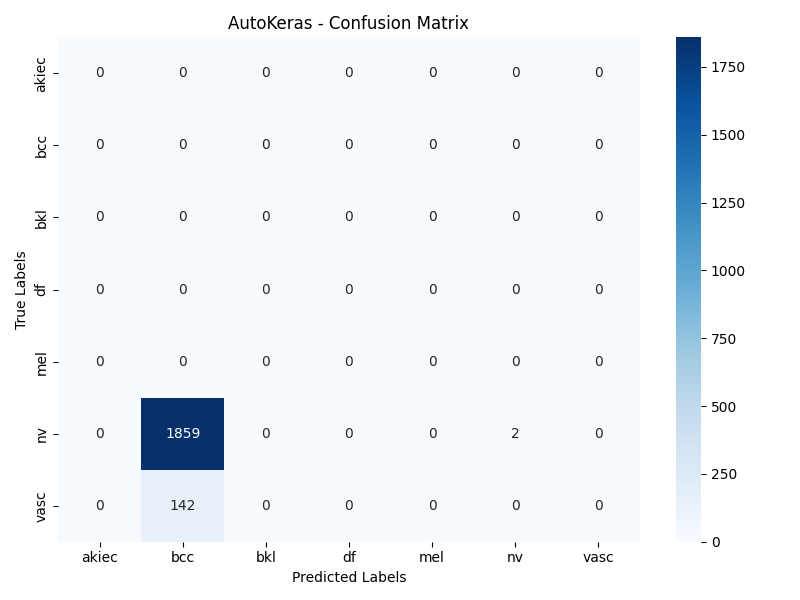


📌 AlexNet Confusion Matrix:


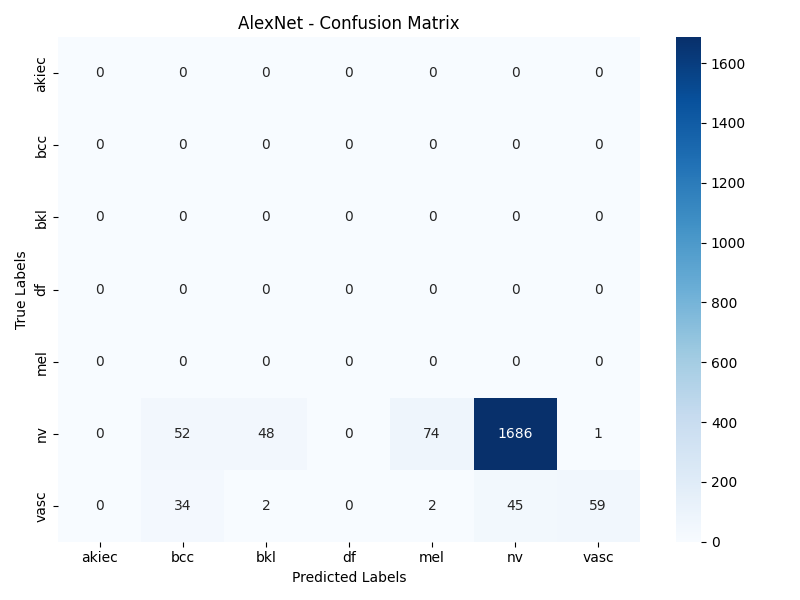


📌 ResNet50 Confusion Matrix:


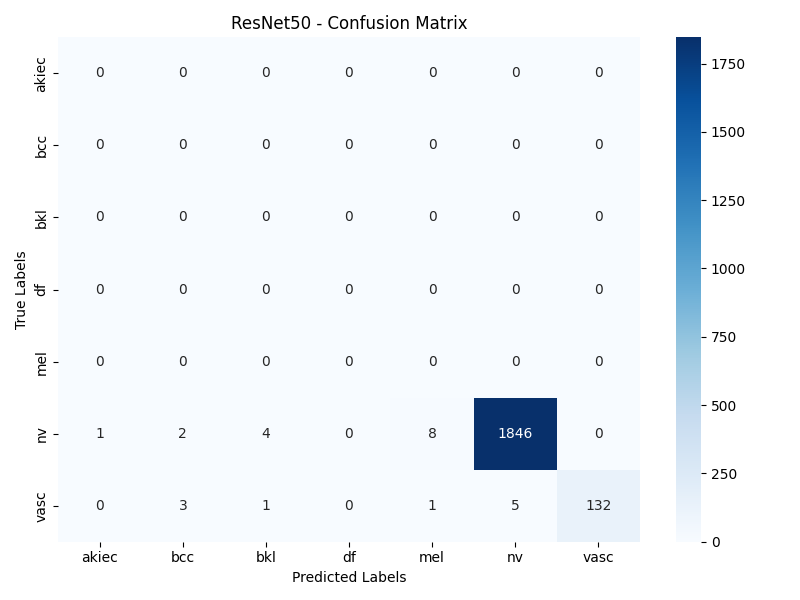


📌 EfficientNetB0 Confusion Matrix:


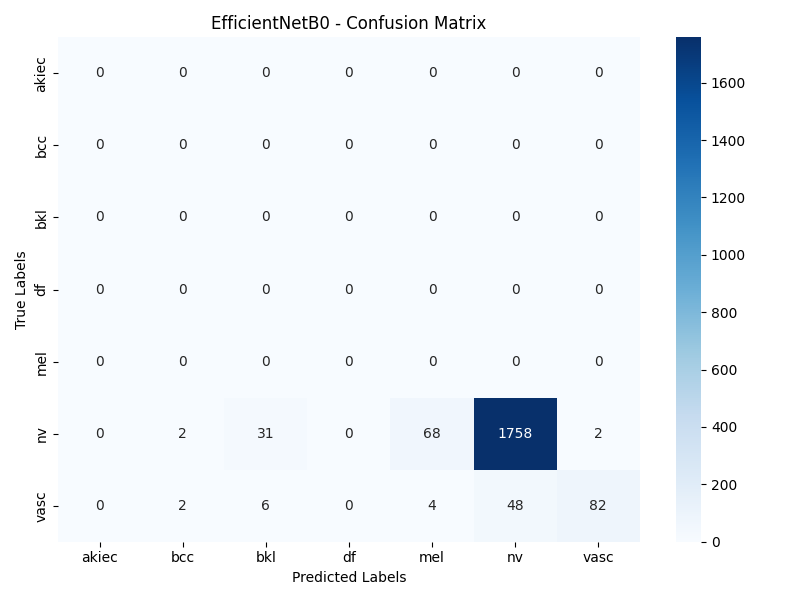

In [ ]:
from IPython.display import Image, display

# Display all confusion matrices from Drive
model_names = ["AutoKeras", "AlexNet", "ResNet50", "EfficientNetB0"]

for model in model_names:
    path = f"/content/drive/MyDrive/HAM10000/confusion_matrices/{model}_confusion_matrix.png"
    print(f"\n📌 {model} Confusion Matrix:")
    display(Image(filename=path))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

def compute_tp_fp_fn_tn(y_true, y_pred, class_names):
    """
    Compute TP, FP, FN, TN, Sensitivity, Specificity for each class
    """
    mcm = multilabel_confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    rows = []

    for i, label in enumerate(class_names):
        tn, fp, fn, tp = mcm[i].ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        rows.append({
            "Class": label,
            "TP": int(tp),
            "FP": int(fp),
            "FN": int(fn),
            "TN": int(tn),
            "Sensitivity (Recall)": round(sensitivity, 4),
            "Specificity": round(specificity, 4)
        })

    return pd.DataFrame(rows)

# Load true labels once
y_true = y_test
class_names = test_ds.class_names

# Loop through predictions
for model_name, model_path in model_paths.items():
    try:
        print(f"\n🔹 Evaluating {model_name}...")

        model = tf.keras.models.load_model(
            model_path,
            custom_objects=ak.CUSTOM_OBJECTS if model_name == "AutoKeras" else None
        )

        if model_name == "AutoKeras":
            preds = model.predict(x_test_autokeras)
        else:
            preds = model.predict(x_test)

        pred_labels = np.argmax(preds, axis=1)

        # Compute TP, FP, FN, TN, Sensitivity, Specificity
        print(f"\n📊 TP, FP, FN, TN Table for {model_name}:")
        result_df = compute_tp_fp_fn_tn(y_true, pred_labels, class_names)
        display(result_df)

    except Exception as e:
        print(f"❌ Error with {model_name}: {e}")



🔹 Evaluating AutoKeras...
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

📊 TP, FP, FN, TN Table for AutoKeras:


Class  TP    FP    FN    TN  Sensitivity (Recall)  Specificity
0  akiec   0     0     0  2003                0.0000        1.000
1    bcc   0  2001     0     2                0.0000        0.001
2    bkl   0     0     0  2003                0.0000        1.000
3     df   0     0     0  2003                0.0000        1.000
4    mel   0     0     0  2003                0.0000        1.000
5     nv   2     0  1859   142                0.0011        1.000
6   vasc   0     0   142  1861                0.0000        1.000


🔹 Evaluating AlexNet...
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step

📊 TP, FP, FN, TN Table for AlexNet:


Class    TP  FP   FN    TN  Sensitivity (Recall)  Specificity
0  akiec     0   0    0  2003                0.0000       1.0000
1    bcc     0  86    0  1917                0.0000       0.9571
2    bkl     0  50    0  1953                0.0000       0.9750
3     df     0   0    0  2003                0.0000       1.0000
4    mel     0  76    0  1927                0.0000       0.9621
5     nv  1686  45  175    97                0.9060       0.6831
6   vasc    59   1   83  1860                0.4155       0.9995


🔹 Evaluating ResNet50...
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step

📊 TP, FP, FN, TN Table for ResNet50:


Class    TP  FP  FN    TN  Sensitivity (Recall)  Specificity
0  akiec     0   1   0  2002                0.0000       0.9995
1    bcc     0   5   0  1998                0.0000       0.9975
2    bkl     0   5   0  1998                0.0000       0.9975
3     df     0   0   0  2003                0.0000       1.0000
4    mel     0   9   0  1994                0.0000       0.9955
5     nv  1846   5  15   137                0.9919       0.9648
6   vasc   132   0  10  1861                0.9296       1.0000


🔹 Evaluating EfficientNetB0...
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step

📊 TP, FP, FN, TN Table for EfficientNetB0:


Class    TP  FP   FN    TN  Sensitivity (Recall)  Specificity
0  akiec     0   0    0  2003                0.0000       1.0000
1    bcc     0   4    0  1999                0.0000       0.9980
2    bkl     0  37    0  1966                0.0000       0.9815
3     df     0   0    0  2003                0.0000       1.0000
4    mel     0  72    0  1931                0.0000       0.9641
5     nv  1758  48  103    94                0.9447       0.6620
6   vasc    82   2   60  1859                0.5775       0.9989

from matplotlib import pyplot as plt
result_df['TP'].plot(kind='hist', bins=20, title='TP')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
result_df['FP'].plot(kind='hist', bins=20, title='FP')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
result_df['FN'].plot(kind='hist', bins=20, title='FN')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
result_df['TN'].plot(kind='hist', bins=20, title='TN')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
result_df.groupby('Class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
result_df.plot(kind='scatter', x='TP', y='FP', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
result_df.plot(kind='scatter', x='FP', y='FN', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
result_df.plot(kind='scatter', x='FN', y='TN', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
result_df.plot(kind='scatter', x='TN', y='Sensitivity (Recall)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
result_df['TP'].plot(kind='line', figsize=(8, 4), title='TP')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
result_df['FP'].plot(kind='line', figsize=(8, 4), title='FP')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
result_df['FN'].plot(kind='line', figsize=(8, 4), title='FN')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
result_df['TN'].plot(kind='line', figsize=(8, 4), title='TN')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(result_df['Class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(result_df, x='TP', y='Class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(result_df['Class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(result_df, x='FP', y='Class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(result_df['Class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(result_df, x='FN', y='Class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(result_df['Class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(result_df, x='TN', y='Class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
!pip install -q mlxtend



🔹 Evaluating AutoKeras...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


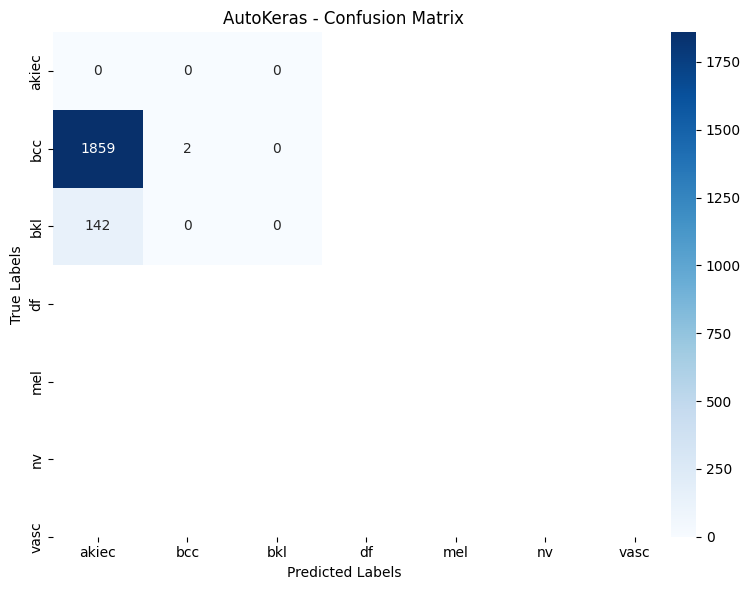


🔹 Evaluating AlexNet...
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step


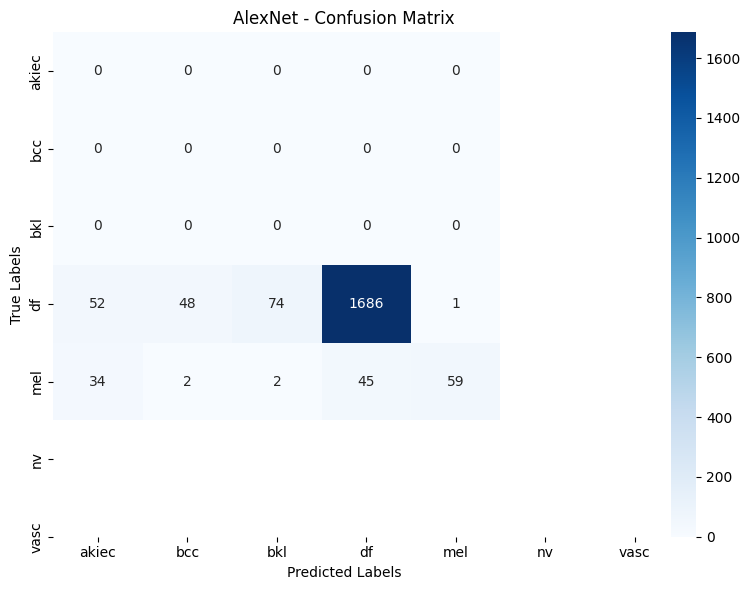


🔹 Evaluating ResNet50...
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step


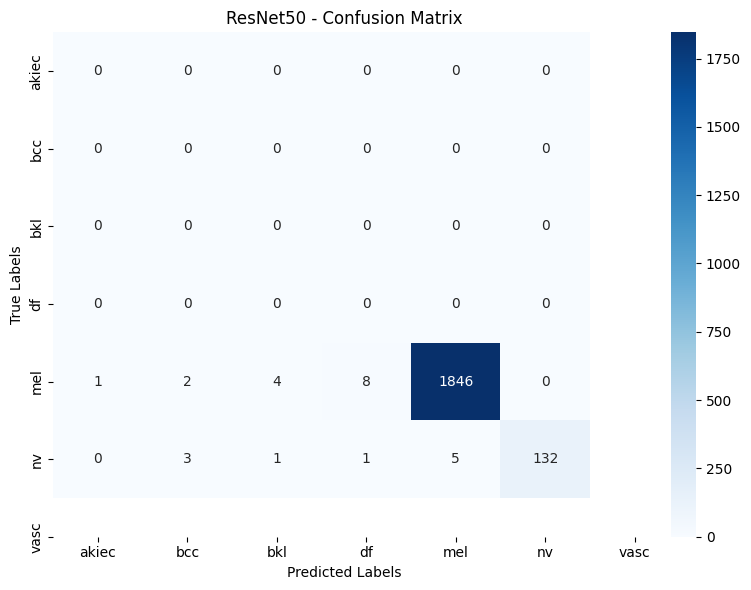


🔹 Evaluating EfficientNetB0...
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step


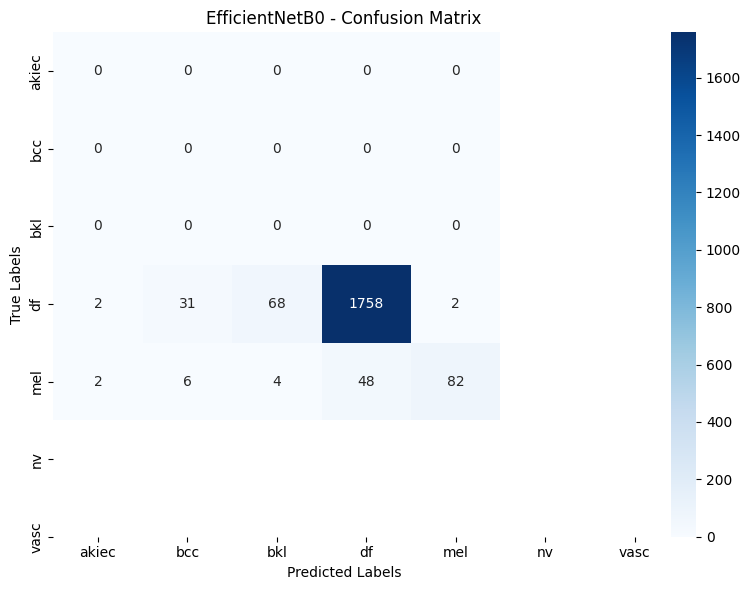

In [ ]:
import tensorflow as tf
import autokeras as ak
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

# Define model paths
model_paths = {
    "AutoKeras": "/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras",
    "AlexNet": "/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras",
    "ResNet50": "/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras",
    "EfficientNetB0": "/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras",
}

# Class names from your dataset
class_names = test_ds.class_names
num_classes = len(class_names)

# Create output folder
output_dir = "/content/drive/MyDrive/HAM10000/confusion_matrices"
os.makedirs(output_dir, exist_ok=True)

# Evaluate and plot confusion matrix
for model_name, model_path in model_paths.items():
    try:
        print(f"\n🔹 Evaluating {model_name}...")

        model = tf.keras.models.load_model(
            model_path,
            custom_objects=ak.CUSTOM_OBJECTS if model_name == "AutoKeras" else None
        )

        # Use resized input for AutoKeras
        if model_name == "AutoKeras":
            y_pred = model.predict(x_test_autokeras)
        else:
            y_pred = model.predict(x_test)

        y_pred_labels = np.argmax(y_pred, axis=1)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred_labels)

        # Plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title(f"{model_name} - Confusion Matrix")
        plt.tight_layout()

        # Save
        save_path = f"{output_dir}/{model_name}_simple_confusion_matrix.png"
        plt.savefig(save_path)
        plt.show()

    except Exception as e:
        print(f"❌ Error with {model_name}: {e}")


Found 10015 files belonging to 7 classes.
Using 2003 files for validation.

🔹 Loading AutoKeras...
🚀 Evaluating AutoKeras...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


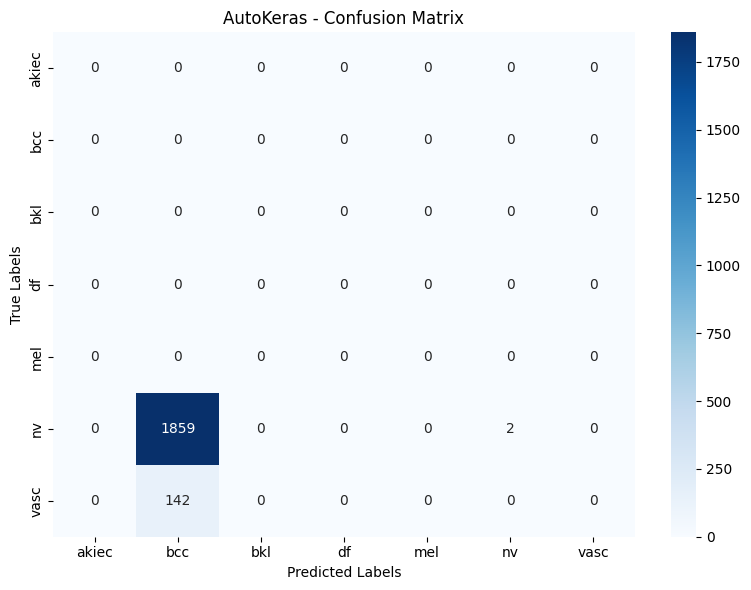


🔹 AutoKeras - Classification Report 🔹
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00         0
         bcc       0.00      0.00      0.00         0
         bkl       0.00      0.00      0.00         0
          df       0.00      0.00      0.00         0
         mel       0.00      0.00      0.00         0
          nv       1.00      0.00      0.00      1861
        vasc       0.00      0.00      0.00       142

    accuracy                           0.00      2003
   macro avg       0.14      0.00      0.00      2003
weighted avg       0.93      0.00      0.00      2003


🔹 Loading AlexNet...
🚀 Evaluating AlexNet...
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


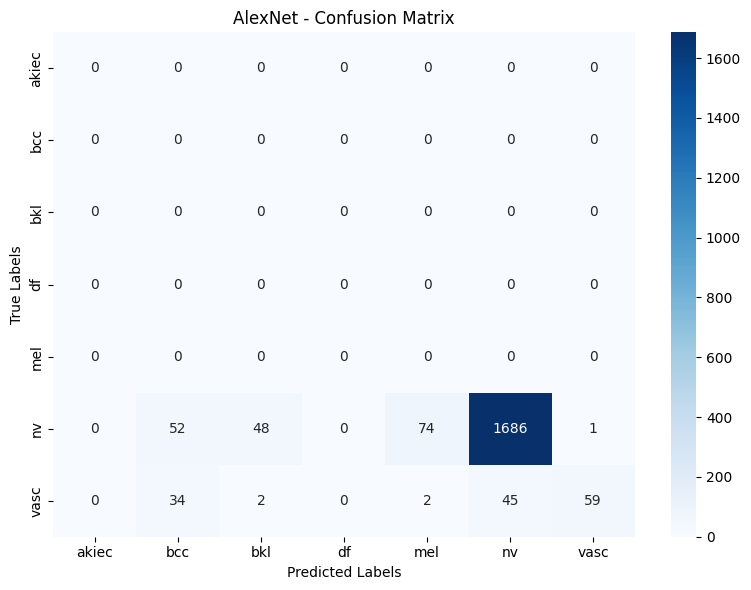


🔹 AlexNet - Classification Report 🔹
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00         0
         bcc       0.00      0.00      0.00         0
         bkl       0.00      0.00      0.00         0
          df       0.00      0.00      0.00         0
         mel       0.00      0.00      0.00         0
          nv       0.97      0.91      0.94      1861
        vasc       0.98      0.42      0.58       142

    accuracy                           0.87      2003
   macro avg       0.28      0.19      0.22      2003
weighted avg       0.97      0.87      0.91      2003


🔹 Loading ResNet50...
🚀 Evaluating ResNet50...
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step


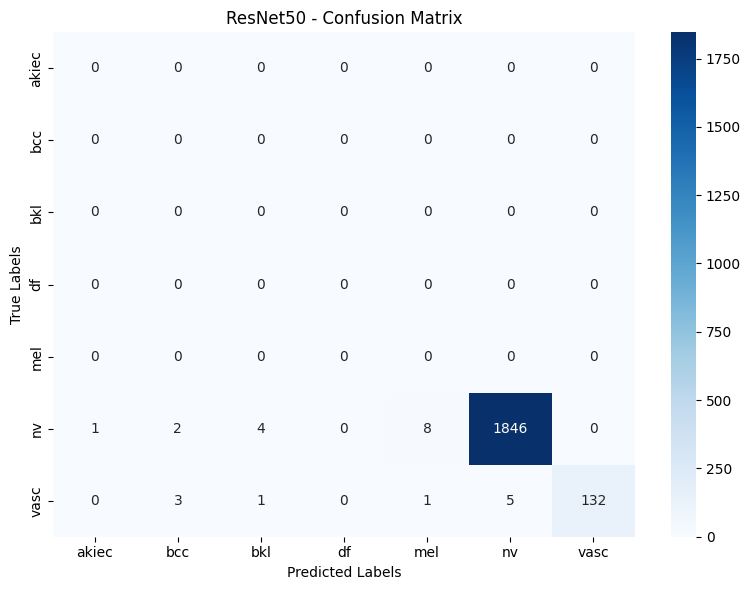


🔹 ResNet50 - Classification Report 🔹
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00         0
         bcc       0.00      0.00      0.00         0
         bkl       0.00      0.00      0.00         0
          df       0.00      0.00      0.00         0
         mel       0.00      0.00      0.00         0
          nv       1.00      0.99      0.99      1861
        vasc       1.00      0.93      0.96       142

    accuracy                           0.99      2003
   macro avg       0.29      0.27      0.28      2003
weighted avg       1.00      0.99      0.99      2003


🔹 Loading EfficientNetB0...
🚀 Evaluating EfficientNetB0...
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step


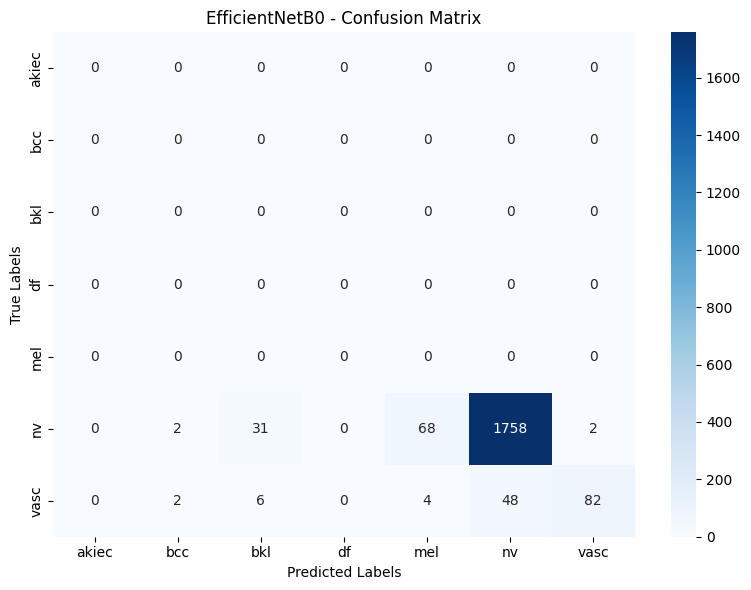


🔹 EfficientNetB0 - Classification Report 🔹
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00         0
         bcc       0.00      0.00      0.00         0
         bkl       0.00      0.00      0.00         0
          df       0.00      0.00      0.00         0
         mel       0.00      0.00      0.00         0
          nv       0.97      0.94      0.96      1861
        vasc       0.98      0.58      0.73       142

    accuracy                           0.92      2003
   macro avg       0.28      0.22      0.24      2003
weighted avg       0.97      0.92      0.94      2003


🔹 Model Accuracy on Full Test Set 🔹
ResNet50: 0.9875
EfficientNetB0: 0.9186
AlexNet: 0.8712
AutoKeras: 0.0010

🏆 Best Model: ResNet50 with 0.9875 accuracy

📊 Sample Comparison Table:
  True Label AutoKeras Prediction AlexNet Prediction ResNet50 Prediction  \
0         nv                  bcc                 nv                  nv   
1         nv           

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
import autokeras as ak
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Paths to models
model_paths = {
    "AutoKeras": "/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras",
    "AlexNet": "/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras",
    "ResNet50": "/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras",
    "EfficientNetB0": "/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras",
}

# Dataset path
data_dir = "/content/drive/MyDrive/HAM10000/images"
img_size = (224, 224)
batch_size = 32

# Load dataset
test_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Get class names
class_names = test_ds.class_names
class_to_index = {name: i for i, name in enumerate(class_names)}
index_to_class = {i: name for name, i in class_to_index.items()}

# Preload all test data (images and labels)
x_test = []
y_test = []

for images, labels in test_ds:
    x_test.extend(images.numpy())
    y_test.extend(labels.numpy())

x_test = np.array(x_test)
y_test = np.array(y_test)
y_test_names = [index_to_class[i] for i in y_test]

# Resize for AutoKeras (assuming AutoKeras model expects 32x32 input)
x_test_autokeras = tf.image.resize(x_test, [32, 32])

# Prepare results
accuracy_results = {}
results_df = pd.DataFrame({"True Label": y_test_names})

# Predict with each model
for model_name, model_path in model_paths.items():
    print(f"\n🔹 Loading {model_name}...")
    model = tf.keras.models.load_model(model_path, custom_objects=ak.CUSTOM_OBJECTS if model_name == "AutoKeras" else None)

    print(f"🚀 Evaluating {model_name}...")

    if model_name == "AutoKeras":
        preds = model.predict(x_test_autokeras)
    else:
        preds = model.predict(x_test)

    pred_labels = np.argmax(preds, axis=1)
    pred_names = [index_to_class[i] for i in pred_labels]

    # Accuracy
    acc = np.mean(pred_labels == y_test)
    accuracy_results[model_name] = acc

    # Add predictions to DataFrame
    results_df[model_name + " Prediction"] = pred_names

    # Confusion Matrix
    cm = confusion_matrix(y_test, pred_labels, labels=list(range(len(class_names))))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.tight_layout()

    # Save confusion matrix plot
    confusion_matrix_save_path = f"/content/drive/MyDrive/HAM10000/confusion_matrices/{model_name}_confusion_matrix.png"
    plt.savefig(confusion_matrix_save_path)
    plt.show()

    # Classification report
    report = classification_report(
        y_test,
        pred_labels,
        labels=list(range(len(class_names))),
        target_names=class_names,
        zero_division=0  # avoids divide-by-zero errors if any class isn't predicted
    )
    print(f"\n🔹 {model_name} - Classification Report 🔹\n{report}")

# Show model-wise accuracy
print("\n🔹 Model Accuracy on Full Test Set 🔹")
for name, acc in sorted(accuracy_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {acc:.4f}")

# Best model
best_model = max(accuracy_results, key=accuracy_results.get)
print(f"\n🏆 Best Model: {best_model} with {accuracy_results[best_model]:.4f} accuracy")

# Preview predictions
print("\n📊 Sample Comparison Table:")
print(results_df.head(10))

# Save results
results_df.to_csv("/content/drive/MyDrive/HAM10000/final_model_predictions_comparison.csv", index=False)
print("✅ Saved predictions comparison to Drive!")


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import autokeras as ak

# Dataset paths
data_dir = "/content/drive/MyDrive/HAM10000/images"
img_size = (224, 224)  # Resize to 224x224 for most models
batch_size = 32

# Load dataset
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Get class names and create mappings
class_names = train_ds.class_names
class_to_index = {name: i for i, name in enumerate(class_names)}
index_to_class = {i: name for name, i in class_to_index.items()}

# Compute class weights to address class imbalance
y_train = np.concatenate([y for _, y in train_ds], axis=0)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Data Augmentation to handle overfitting
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model Checkpoint to save the model in case of session crash
checkpoint_callback = ModelCheckpoint(
    "/content/drive/MyDrive/HAM10000/model_checkpoint.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# Function to prepare and train models
def prepare_and_train_model(model, model_name, train_ds, val_ds, class_weight_dict):
    print(f"🔹 Training {model_name}...")

    model.fit(train_ds,
              epochs=20,
              validation_data=val_ds,
              class_weight=class_weight_dict,
              callbacks=[early_stopping, checkpoint_callback])

    print(f"🔹 {model_name} - Training Complete!")

# ---- AutoKeras Model ----
auto_keras_model = ak.ImageClassifier(max_trials=1, overwrite=True)  # Initialize AutoKeras image classifier
auto_keras_model.fit(train_ds, epochs=10)  # Fit model to the dataset
prepare_and_train_model(auto_keras_model, "AutoKeras", train_ds, val_ds, class_weight_dict)

# ---- AlexNet Model ----
alexnet_model = tf.keras.models.load_model("/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras")
prepare_and_train_model(alexnet_model, "AlexNet", train_ds, val_ds, class_weight_dict)

# ---- ResNet50 Model ----
resnet50_model = tf.keras.models.load_model("/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras")
prepare_and_train_model(resnet50_model, "ResNet50", train_ds, val_ds, class_weight_dict)

# ---- EfficientNetB0 Model ----
efficientnetb0_model = tf.keras.models.load_model("/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras")
prepare_and_train_model(efficientnetb0_model, "EfficientNetB0", train_ds, val_ds, class_weight_dict)


Trial 1 Complete [01h 09m 56s]
val_loss: 1.1168230772018433

Best val_loss So Far: 1.1168230772018433
Total elapsed time: 01h 09m 56s
Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.5892 - loss: 3.2337
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.6559 - loss: 1.2794
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.6573 - loss: 1.2261
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.6549 - loss: 1.2227
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.6550 - loss: 1.2109
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.6543 - loss: 1.1974
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.6575 - loss: 1.1814
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.6596 - loss: 1.1773
Epoch 9/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.6569 - loss: 1.1812
Epoch 10/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.6590 - loss: 1.

251/251 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.3907 - loss: 2.0165 - val_accuracy: 0.0704 - val_loss: 2.1062
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.1230 - loss: 2.1571
Epoch 2: val_loss did not improve from 2.10621
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 321ms/step - accuracy: 0.1230 - loss: 2.1569 - val_accuracy: 0.0130 - val_loss: 2.1091
Epoch 3/50
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.0377 - loss: 2.1135
Epoch 3: val_loss improved from 2.10621 to 1.96685, saving model to /content/drive/MyDrive/HAM10000/model_checkpoint.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 92s 362ms/step - accuracy: 0.0378 - loss: 2.1130 - val_accuracy: 0.0130 - val_loss: 1.9669
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.0813 - loss: 2.0738
Epoch 4: val_loss did not improve from 1.96685
251/251 ━━━━━━━━━━━━━━━━━━━━ 100s 400ms/step - accuracy: 0.0812 - loss: 2.0736 - val_accuracy: 0.0130 - val_loss: 1.9816
Epoch 5/50
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.0468 - loss: 2.0512
Epoch 5: val_loss did not improve from 1.96685
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 317ms/step - accuracy: 0.0468 - loss: 2.0508 - val_accuracy: 0.0130 - val_loss: 1.9675
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.0587 - loss: 2.0369
Epoch 6: val_loss improved from 1.96685 to 1.95122, saving model to /content/drive/MyDrive/HAM10000/model_checkpoint.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 121s 472ms/step - accuracy: 0.0587 - loss: 2.0367 - val_accuracy: 0.0130 - val_loss: 1.9512
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.0767 - loss: 2.0041
Epoch 7: val_loss improved from 1.95122 to 1.93958, saving model to /content/drive/MyDrive/HAM10000/model_checkpoint.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 131s 428ms/step - accuracy: 0.0767 - loss: 2.0041 - val_accuracy: 0.0130 - val_loss: 1.9396
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.0675 - loss: 2.0252
Epoch 8: val_loss did not improve from 1.93958
251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 354ms/step - accuracy: 0.0675 - loss: 2.0250 - val_accuracy: 0.0130 - val_loss: 1.9443
Epoch 9/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.0512 - loss: 2.0191
Epoch 9: val_loss improved from 1.93958 to 1.93154, saving model to /content/drive/MyDrive/HAM10000/model_checkpoint.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 98s 393ms/step - accuracy: 0.0513 - loss: 2.0189 - val_accuracy: 0.0130 - val_loss: 1.9315
Epoch 10/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.0919 - loss: 1.9897
Epoch 10: val_loss did not improve from 1.93154
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 333ms/step - accuracy: 0.0919 - loss: 1.9896 - val_accuracy: 0.0130 - val_loss: 1.9339
Epoch 11/50
180/251 ━━━━━━━━━━━━━━━━━━━━ 18s 261ms/step - accuracy: 0.0834 - loss: 2.0194

In [ ]:
!pip install autokeras --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.0 MB/s eta 0:00:00



🔹 Loading AutoKeras model...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


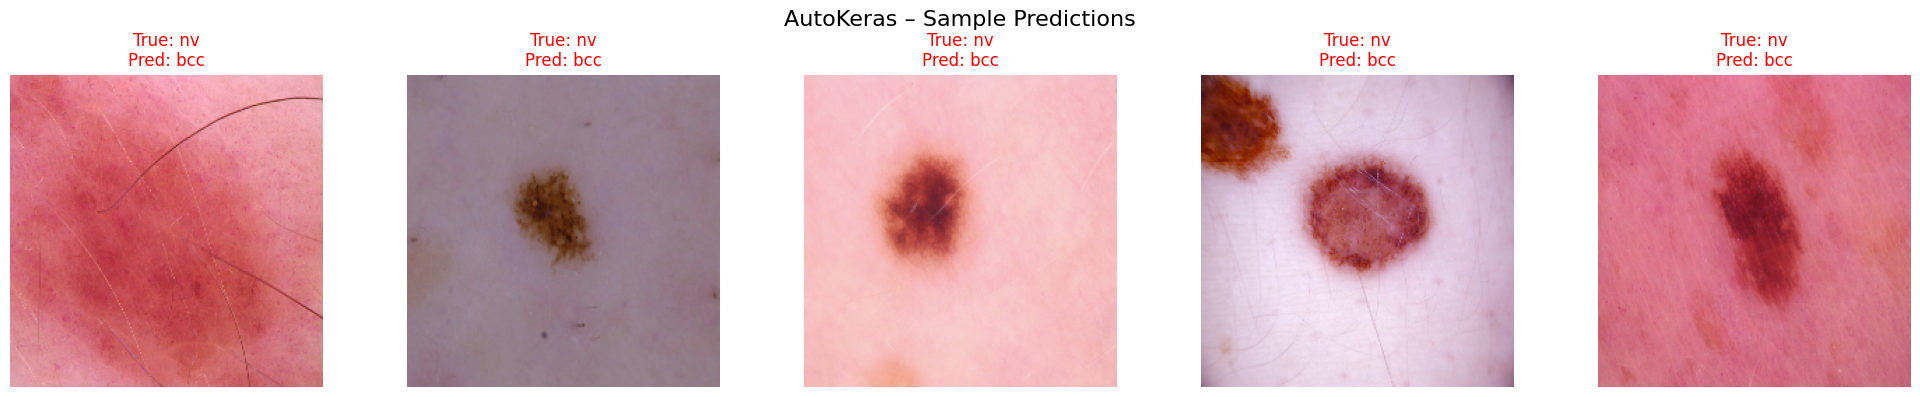


🔹 Loading AlexNet model...


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<Figure size 640x480 with 0 Axes>

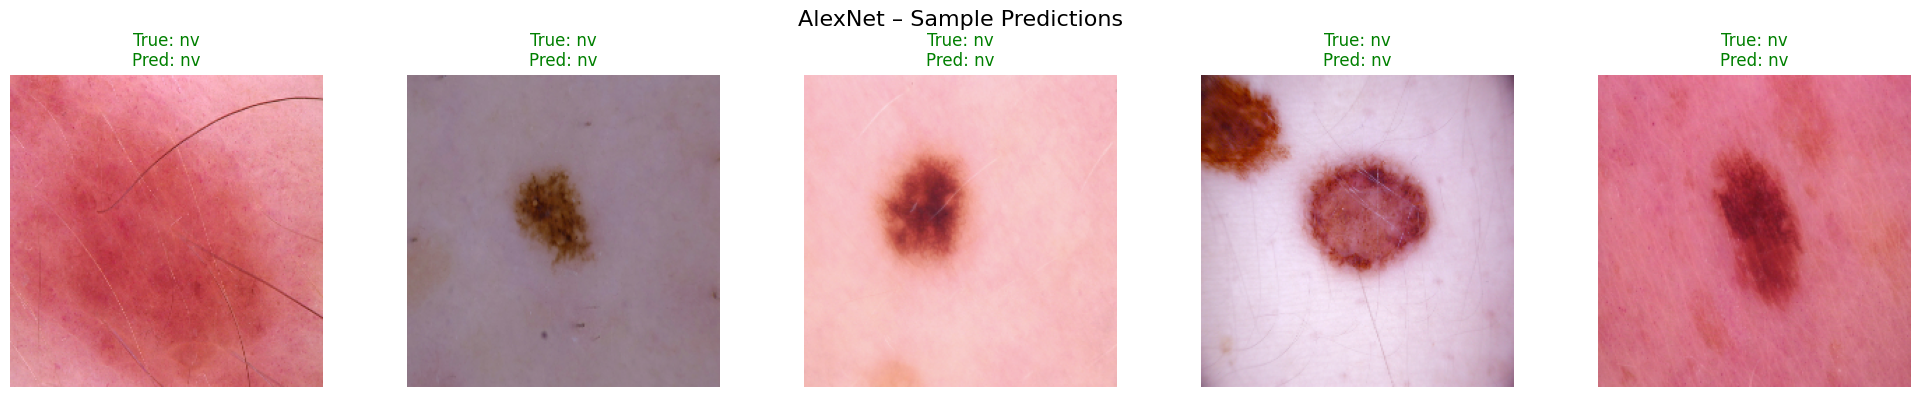


🔹 Loading ResNet50 model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


<Figure size 640x480 with 0 Axes>

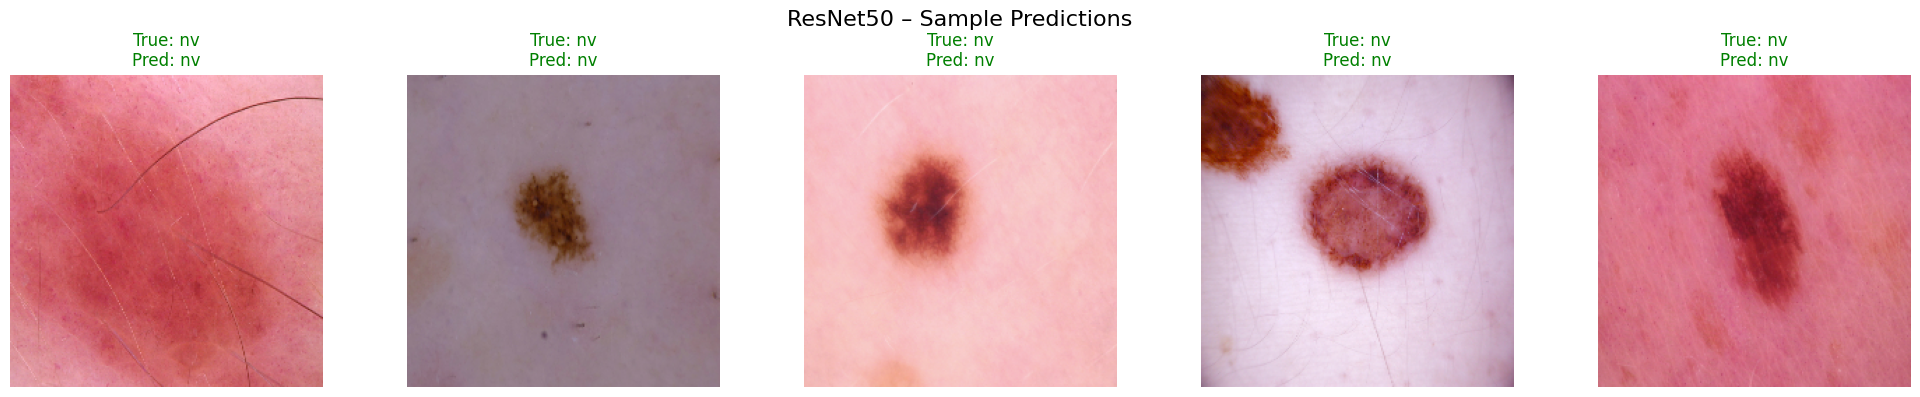


🔹 Loading EfficientNetB0 model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


<Figure size 640x480 with 0 Axes>

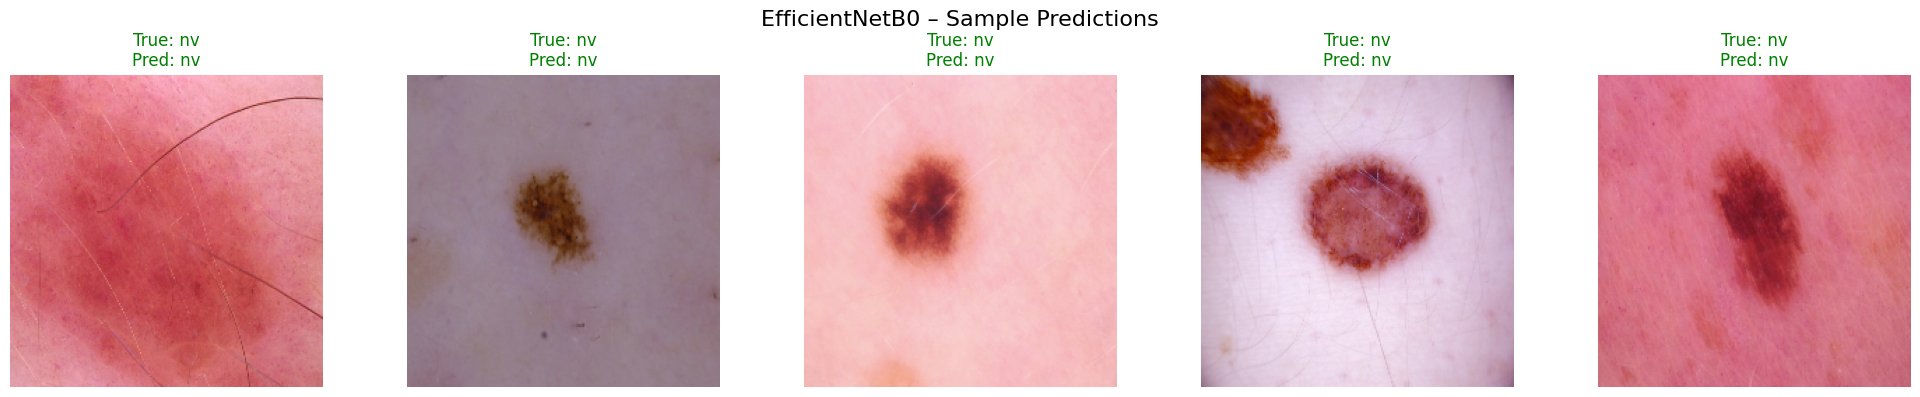

<Figure size 640x480 with 0 Axes>

In [ ]:
import tensorflow as tf
import autokeras as ak
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Ensure test data is NumPy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# Model paths
model_paths = {
    "AutoKeras": "/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras",
    "AlexNet": "/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras",
    "ResNet50": "/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras",
    "EfficientNetB0": "/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras",
}

# Class names
class_names = test_ds.class_names

# Randomly select 5 indices (same for all models)
num_samples = 5
sample_indices = random.sample(range(len(x_test)), num_samples)

# Optional: create output folder
output_dir = "/content/drive/MyDrive/HAM10000/prediction_samples"
os.makedirs(output_dir, exist_ok=True)

# Predict and plot for each model
for model_name, model_path in model_paths.items():
    try:
        print(f"\n🔹 Loading {model_name} model...")
        model = tf.keras.models.load_model(
            model_path,
            custom_objects=ak.CUSTOM_OBJECTS if model_name == "AutoKeras" else None
        )

        # Prepare input
        if model_name == "AutoKeras":
            x_input = tf.image.resize(x_test[sample_indices], [32, 32])
        else:
            x_input = x_test[sample_indices]

        preds = model.predict(x_input)
        pred_indices = np.argmax(preds, axis=1)

        # Plot predictions
        plt.figure(figsize=(20, 4))
        for i, idx in enumerate(sample_indices):
            img = x_test[idx].astype("uint8")
            true_label = class_names[y_test[idx]]
            pred_label = class_names[pred_indices[i]]
            color = 'green' if true_label == pred_label else 'red'

            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
            plt.axis('off')

        plt.suptitle(f"{model_name} – Sample Predictions", fontsize=16)
        plt.tight_layout()
        plt.show()

        # Optional: Save figure to Drive
        plt.savefig(f"{output_dir}/{model_name}_sample_predictions.png")

    except Exception as e:
        print(f"❌ Error with {model_name}: {e}")


⚠️ Warning: Class akiec not found in test set!
⚠️ Warning: Class bcc not found in test set!
⚠️ Warning: Class bkl not found in test set!
⚠️ Warning: Class df not found in test set!
⚠️ Warning: Class mel not found in test set!
⚠️ Warning: Class vasc not found in test set!

🔹 Loading AutoKeras model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


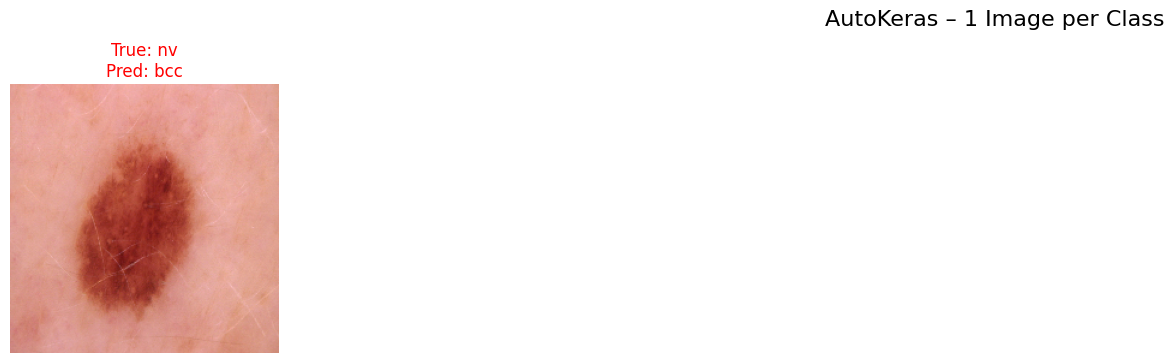


🔹 Loading AlexNet model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<Figure size 640x480 with 0 Axes>

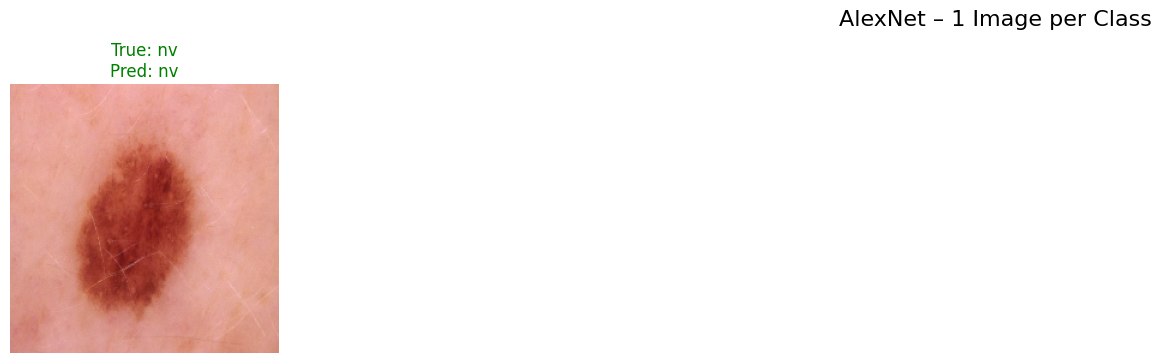


🔹 Loading ResNet50 model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


<Figure size 640x480 with 0 Axes>

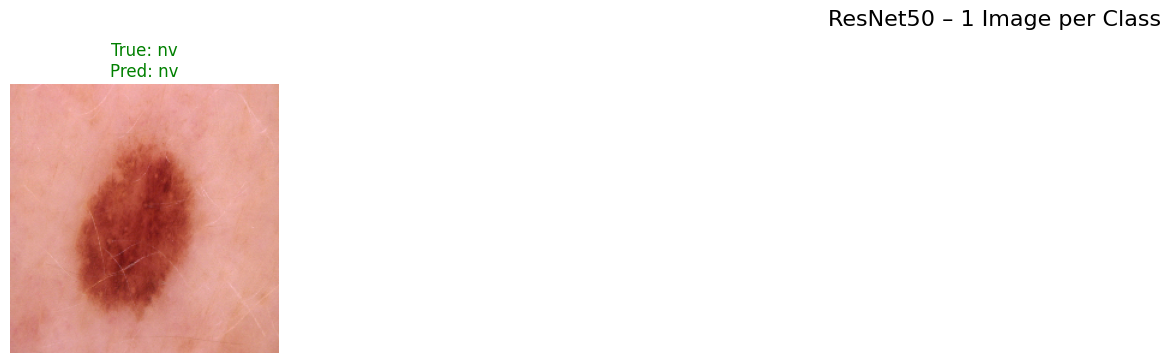


🔹 Loading EfficientNetB0 model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


<Figure size 640x480 with 0 Axes>

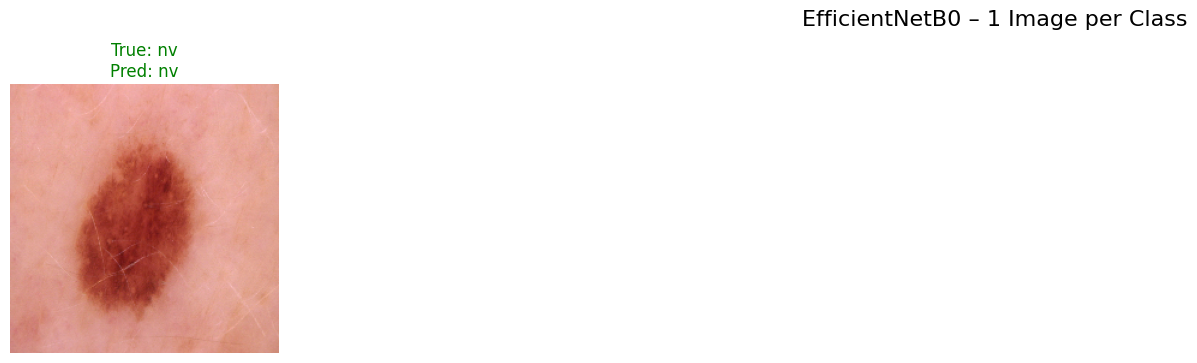

<Figure size 640x480 with 0 Axes>

In [ ]:
import tensorflow as tf
import autokeras as ak
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure data is in NumPy format
x_test = np.array(x_test)
y_test = np.array(y_test)

# Model paths
model_paths = {
    "AutoKeras": "/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras",
    "AlexNet": "/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras",
    "ResNet50": "/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras",
    "EfficientNetB0": "/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras",
}

# Class names
class_names = test_ds.class_names
num_classes = len(class_names)

# Find 1 index per class from test set
sample_indices = []
for class_index in range(num_classes):
    class_idxs = np.where(y_test == class_index)[0]
    if len(class_idxs) > 0:
        sample_indices.append(class_idxs[0])
    else:
        print(f"⚠️ Warning: Class {class_names[class_index]} not found in test set!")

# Output directory
output_dir = "/content/drive/MyDrive/HAM10000/prediction_samples_per_class"
os.makedirs(output_dir, exist_ok=True)

# Predict on 1 sample per class
for model_name, model_path in model_paths.items():
    try:
        print(f"\n🔹 Loading {model_name} model...")
        model = tf.keras.models.load_model(
            model_path,
            custom_objects=ak.CUSTOM_OBJECTS if model_name == "AutoKeras" else None
        )

        # Prepare input
        if model_name == "AutoKeras":
            x_input = tf.image.resize(x_test[sample_indices], [32, 32])
        else:
            x_input = x_test[sample_indices]

        preds = model.predict(x_input)
        pred_indices = np.argmax(preds, axis=1)

        # Plot
        plt.figure(figsize=(20, 4))
        for i, idx in enumerate(sample_indices):
            img = x_test[idx].astype("uint8")
            true_label = class_names[y_test[idx]]
            pred_label = class_names[pred_indices[i]]
            color = 'green' if true_label == pred_label else 'red'

            plt.subplot(1, num_classes, i + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
            plt.axis('off')

        plt.suptitle(f"{model_name} – 1 Image per Class", fontsize=16)
        plt.tight_layout()
        plt.show()

        # Optional: Save plot
        plt.savefig(f"{output_dir}/{model_name}_per_class_predictions.png")

    except Exception as e:
        print(f"❌ Error with {model_name}: {e}")


Found 10015 files belonging to 7 classes.
Using 2003 files for validation.

🔹 Loading AutoKeras...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
❌ Error with AutoKeras: index 2 is out of bounds for axis 0 with size 2

🔹 Loading AlexNet...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
❌ Error with AlexNet: index 2 is out of bounds for axis 0 with size 2

🔹 Loading ResNet50...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
❌ Error with ResNet50: index 2 is out of bounds for axis 0 with size 2

🔹 Loading EfficientNetB0...
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
❌ Error with EfficientNetB0: index 2 is out of bounds for axis 0 with size 2


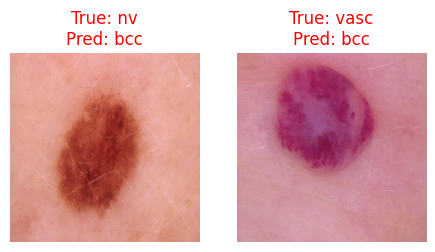

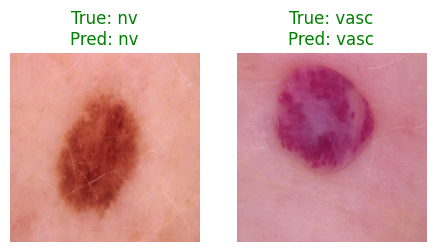

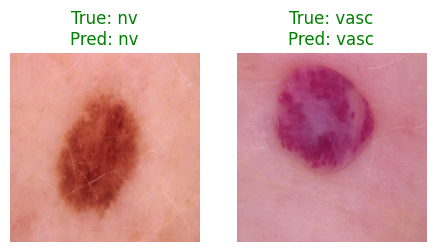

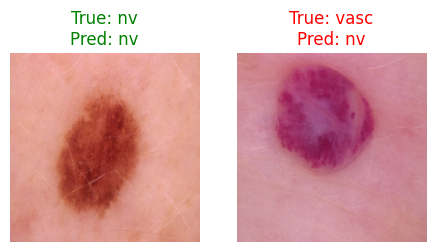

In [ ]:
import tensorflow as tf
import autokeras as ak
import matplotlib.pyplot as plt
import numpy as np
import os

# Reload test set directly from directory to ensure class variety
data_dir = "/content/drive/MyDrive/HAM10000/images"
img_size = (224, 224)
batch_size = 32

raw_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=1,  # load one at a time for selection
    shuffle=False
)

# Map index to class name
class_names = raw_test_ds.class_names
index_to_class = {i: name for i, name in enumerate(class_names)}
num_classes = len(class_names)

# Find one image per class
x_classwise = []
y_classwise = []

class_seen = set()
for image, label in raw_test_ds.unbatch():
    label_val = int(label.numpy())
    if label_val not in class_seen:
        x_classwise.append(image.numpy())
        y_classwise.append(label_val)
        class_seen.add(label_val)
    if len(class_seen) == num_classes:
        break

x_classwise = np.array(x_classwise)
y_classwise = np.array(y_classwise)

# Model paths
model_paths = {
    "AutoKeras": "/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras",
    "AlexNet": "/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras",
    "ResNet50": "/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras",
    "EfficientNetB0": "/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras",
}

# Output directory
output_dir = "/content/drive/MyDrive/HAM10000/prediction_samples_per_class"
os.makedirs(output_dir, exist_ok=True)

# Evaluate and visualize for each model
for model_name, model_path in model_paths.items():
    try:
        print(f"\n🔹 Loading {model_name}...")
        model = tf.keras.models.load_model(
            model_path,
            custom_objects=ak.CUSTOM_OBJECTS if model_name == "AutoKeras" else None
        )

        # Resize for AutoKeras if needed
        x_input = tf.image.resize(x_classwise, [32, 32]) if model_name == "AutoKeras" else x_classwise

        preds = model.predict(x_input)
        pred_indices = np.argmax(preds, axis=1)

        # Plot
        plt.figure(figsize=(20, 4))
        for i in range(num_classes):
            img = x_classwise[i].astype("uint8")
            true_label = class_names[y_classwise[i]]
            pred_label = class_names[pred_indices[i]]
            color = 'green' if true_label == pred_label else 'red'

            plt.subplot(1, num_classes, i + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
            plt.axis('off')

        plt.suptitle(f"{model_name} – 1 Image per Class", fontsize=16)
        plt.tight_layout()
        plt.show()

        # Save figure
        plt.savefig(f"{output_dir}/{model_name}_per_class_predictions.png")

    except Exception as e:
        print(f"❌ Error with {model_name}: {e}")


Found 10015 files belonging to 7 classes.
Using 2003 files for validation.

🔹 Loading AutoKeras...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
✅ AutoKeras output shape: (2, 7)


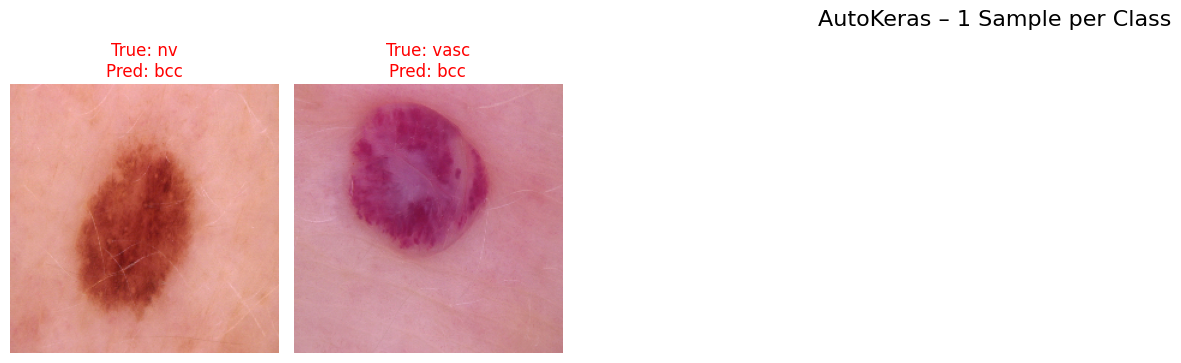


🔹 Loading AlexNet...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
✅ AlexNet output shape: (2, 7)


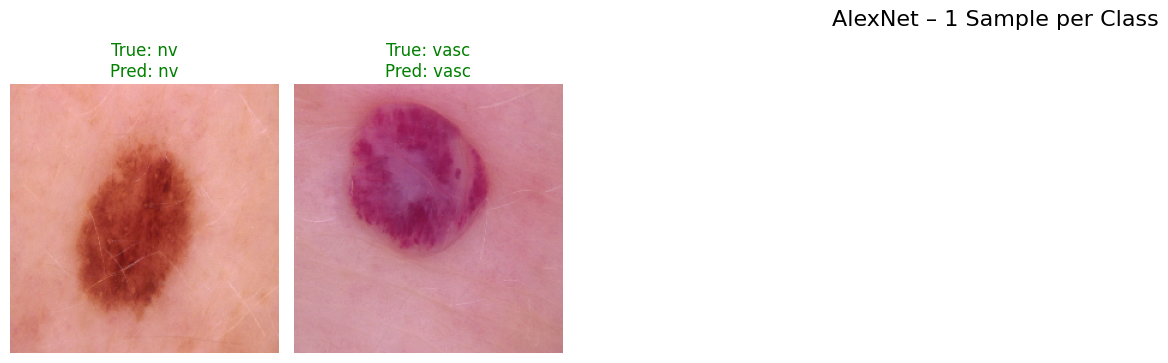


🔹 Loading ResNet50...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
✅ ResNet50 output shape: (2, 7)


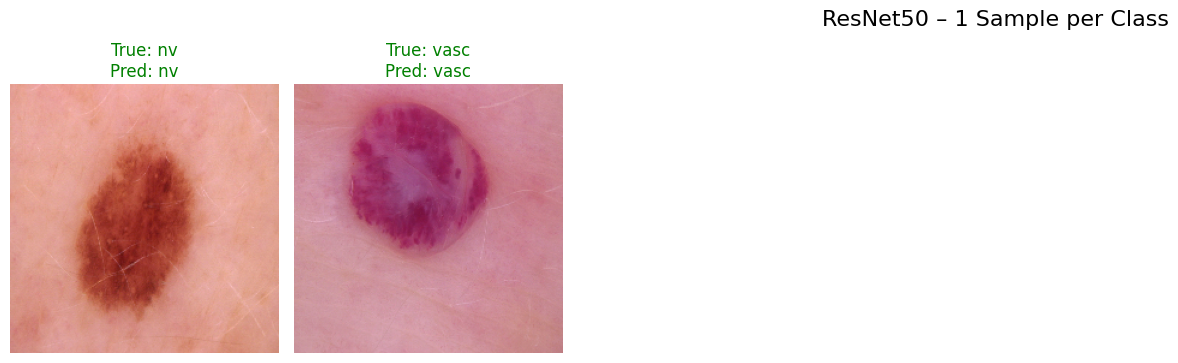


🔹 Loading EfficientNetB0...
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
✅ EfficientNetB0 output shape: (2, 7)


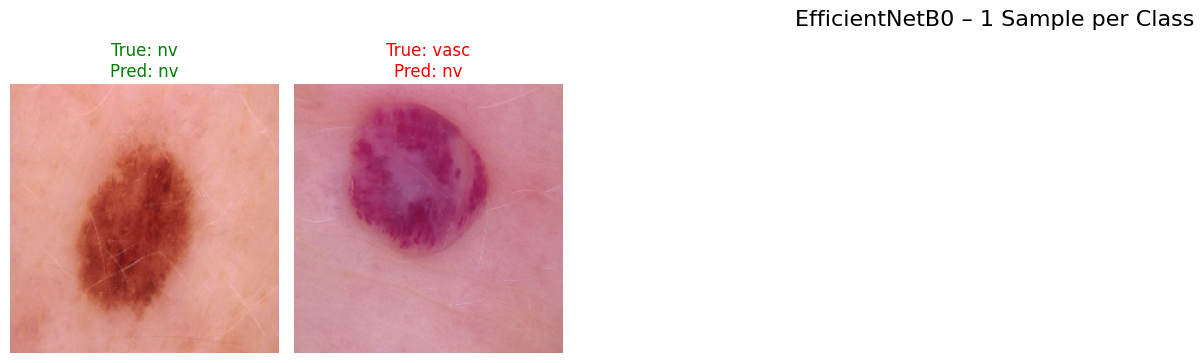

In [ ]:
import tensorflow as tf
import autokeras as ak
import matplotlib.pyplot as plt
import numpy as np
import os

# ------------------ Load Fresh Validation Set with All 7 Classes ------------------

data_dir = "/content/drive/MyDrive/HAM10000/images"
img_size = (224, 224)

raw_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=1,
    shuffle=False
)

# Get class info
class_names = raw_test_ds.class_names
index_to_class = {i: name for i, name in enumerate(class_names)}
num_classes = len(class_names)

# ------------------ Find One Image per Class ------------------

x_classwise = []
y_classwise = []
class_seen = set()

for image, label in raw_test_ds.unbatch():
    label_val = int(label.numpy())
    if label_val not in class_seen:
        x_classwise.append(image.numpy())
        y_classwise.append(label_val)
        class_seen.add(label_val)
    if len(class_seen) == num_classes:
        break

x_classwise = np.array(x_classwise)
y_classwise = np.array(y_classwise)

# ------------------ Model Paths ------------------

model_paths = {
    "AutoKeras": "/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras",
    "AlexNet": "/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras",
    "ResNet50": "/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras",
    "EfficientNetB0": "/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras",
}

# ------------------ Predict and Plot ------------------

output_dir = "/content/drive/MyDrive/HAM10000/prediction_samples_per_class"
os.makedirs(output_dir, exist_ok=True)

for model_name, model_path in model_paths.items():
    try:
        print(f"\n🔹 Loading {model_name}...")
        model = tf.keras.models.load_model(
            model_path,
            custom_objects=ak.CUSTOM_OBJECTS if model_name == "AutoKeras" else None
        )

        x_input = tf.image.resize(x_classwise, [32, 32]) if model_name == "AutoKeras" else x_classwise

        preds = model.predict(x_input)
        pred_indices = np.argmax(preds, axis=1)

        print(f"✅ {model_name} output shape: {preds.shape}")

        # Plot
        plt.figure(figsize=(20, 4))
        for i in range(len(x_classwise)):
            img = x_classwise[i].astype("uint8")
            true_label = class_names[y_classwise[i]]

            try:
                pred_label = class_names[pred_indices[i]]
                color = 'green' if pred_label == true_label else 'red'
            except IndexError:
                pred_label = f"Invalid Index {pred_indices[i]}"
                color = 'orange'
                print(f"⚠️ {model_name} predicted class index {pred_indices[i]}, which is out of range.")

            plt.subplot(1, num_classes, i + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
            plt.axis('off')

        plt.suptitle(f"{model_name} – 1 Sample per Class", fontsize=16)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/{model_name}_per_class_predictions.png")
        plt.show()

    except Exception as e:
        print(f"❌ Error with {model_name}: {e}")



🔹 Loading AutoKeras...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step

📊 Classification Report – AutoKeras
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       0.0
         bcc       0.00      0.00      0.00       0.0
         bkl       0.00      0.00      0.00       0.0
          df       0.00      0.00      0.00       0.0
         mel       0.00      0.00      0.00       0.0
          nv       0.00      0.00      0.00       1.0
        vasc       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



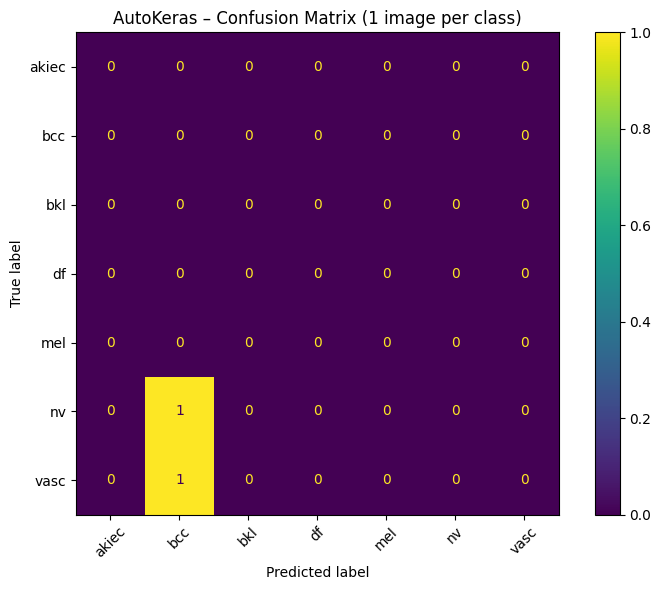


🔹 Loading AlexNet...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

📊 Classification Report – AlexNet
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00         0
         bcc       0.00      0.00      0.00         0
         bkl       0.00      0.00      0.00         0
          df       0.00      0.00      0.00         0
         mel       0.00      0.00      0.00         0
          nv       1.00      1.00      1.00         1
        vasc       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       0.29      0.29      0.29         2
weighted avg       1.00      1.00      1.00         2



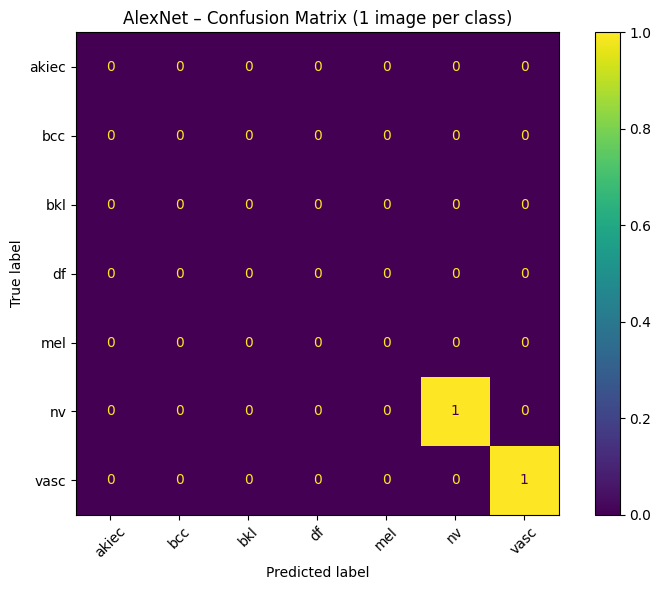


🔹 Loading ResNet50...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

📊 Classification Report – ResNet50
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00         0
         bcc       0.00      0.00      0.00         0
         bkl       0.00      0.00      0.00         0
          df       0.00      0.00      0.00         0
         mel       0.00      0.00      0.00         0
          nv       1.00      1.00      1.00         1
        vasc       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       0.29      0.29      0.29         2
weighted avg       1.00      1.00      1.00         2



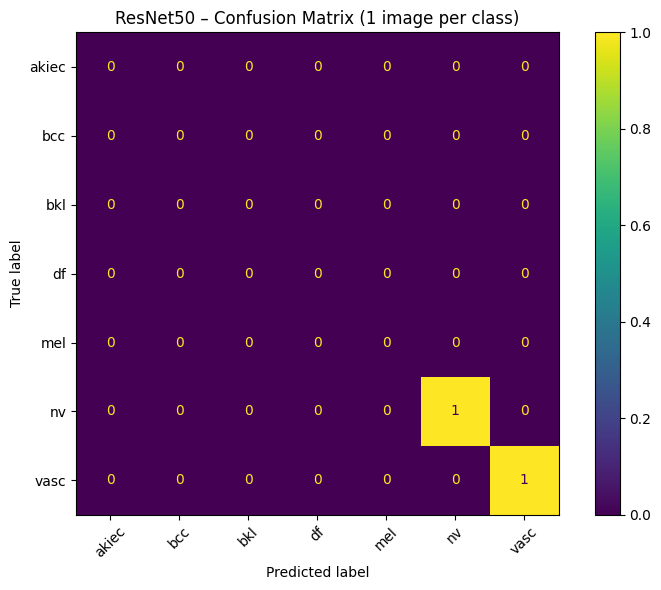


🔹 Loading EfficientNetB0...
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

📊 Classification Report – EfficientNetB0
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00         0
         bcc       0.00      0.00      0.00         0
         bkl       0.00      0.00      0.00         0
          df       0.00      0.00      0.00         0
         mel       0.00      0.00      0.00         0
          nv       0.50      1.00      0.67         1
        vasc       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.07      0.14      0.10         2
weighted avg       0.25      0.50      0.33         2



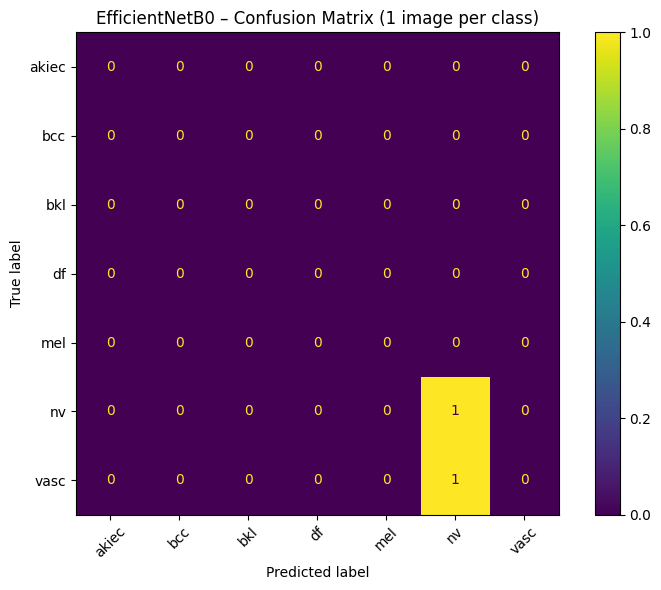

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import autokeras as ak
import os

# Class names and number
class_names = raw_test_ds.class_names
num_classes = len(class_names)

# Already prepared: 1 image per class
x_classwise = np.array(x_classwise)
y_classwise = np.array(y_classwise)

# Model paths
model_paths = {
    "AutoKeras": "/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras",
    "AlexNet": "/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras",
    "ResNet50": "/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras",
    "EfficientNetB0": "/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras",
}

# Output path
output_dir = "/content/drive/MyDrive/HAM10000/confusion_matrices_small_sample"
os.makedirs(output_dir, exist_ok=True)

# Evaluate and plot
for model_name, model_path in model_paths.items():
    try:
        print(f"\n🔹 Loading {model_name}...")
        model = tf.keras.models.load_model(
            model_path,
            custom_objects=ak.CUSTOM_OBJECTS if model_name == "AutoKeras" else None
        )

        x_input = tf.image.resize(x_classwise, [32, 32]) if model_name == "AutoKeras" else x_classwise

        preds = model.predict(x_input)
        y_pred = np.argmax(preds, axis=1)
        y_true = y_classwise

        print(f"\n📊 Classification Report – {model_name}")
        print(classification_report(
            y_true, y_pred,
            labels=list(range(num_classes)),
            target_names=class_names,
            zero_division=0
        ))

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(ax=ax, cmap='viridis', xticks_rotation=45)
        plt.title(f"{model_name} – Confusion Matrix (1 image per class)")
        plt.tight_layout()
        plt.savefig(f"{output_dir}/{model_name}_confusion_matrix_small_sample.png")
        plt.show()

    except Exception as e:
        print(f"❌ Error with {model_name}: {e}")


Found 10015 files belonging to 7 classes.
Using 2003 files for validation.
✅ Created balanced test set with shape: (10, 224, 224, 3)

🔹 Loading AutoKeras...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   

📊 Classification Report – AutoKeras
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       0.0
         bcc       0.00      0.00      0.00       0.0
         bkl       0.00      0.00      0.00       0.0
          df       0.00      0.00      0.00       0.0
         mel       0.00      0.00      0.00       0.0
          nv       0.00      0.00      0.00      10.0
        vasc       0.00      0.00      0.00       0.0

    accuracy                           0.00      10.0
   macro avg       0.00      0.00      0.00      10.0
weighted avg       0.00      0.00      0.00      10.0



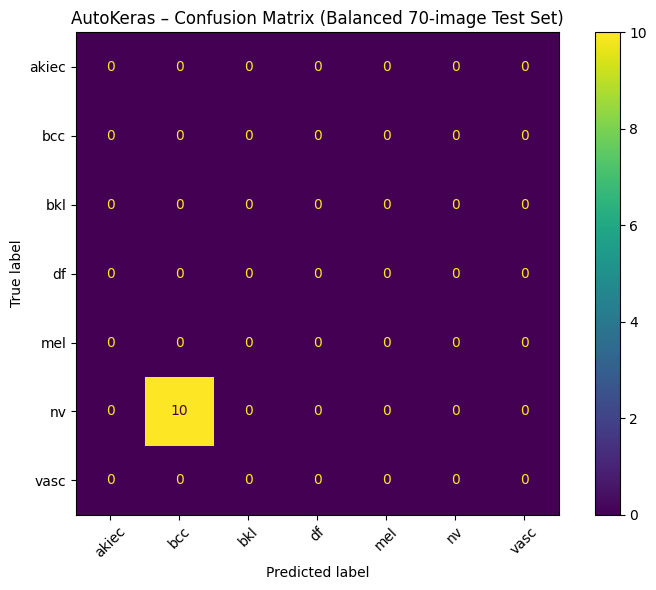


🔹 Loading AlexNet...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

📊 Classification Report – AlexNet
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00         0
         bcc       0.00      0.00      0.00         0
         bkl       0.00      0.00      0.00         0
          df       0.00      0.00      0.00         0
         mel       0.00      0.00      0.00         0
          nv       1.00      1.00      1.00        10
        vasc       0.00      0.00      0.00         0

    accuracy                           1.00        10
   macro avg       0.14      0.14      0.14        10
weighted avg       1.00      1.00      1.00        10



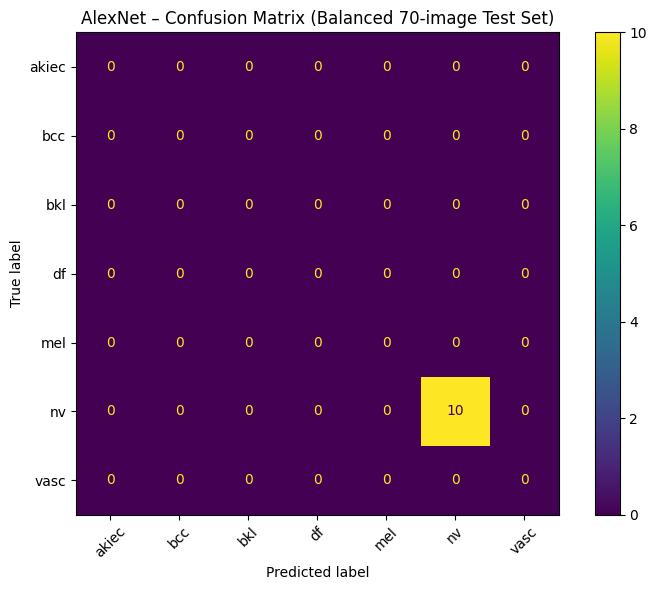


🔹 Loading ResNet50...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

📊 Classification Report – ResNet50
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00         0
         bcc       0.00      0.00      0.00         0
         bkl       0.00      0.00      0.00         0
          df       0.00      0.00      0.00         0
         mel       0.00      0.00      0.00         0
          nv       1.00      1.00      1.00        10
        vasc       0.00      0.00      0.00         0

    accuracy                           1.00        10
   macro avg       0.14      0.14      0.14        10
weighted avg       1.00      1.00      1.00        10



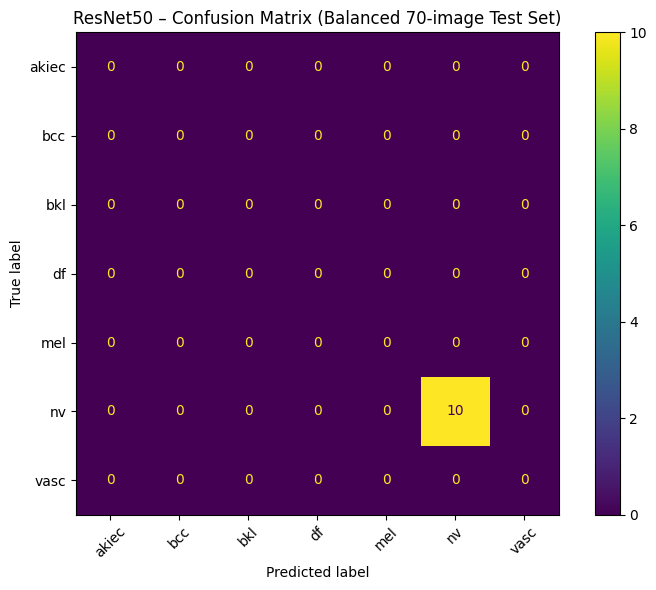


🔹 Loading EfficientNetB0...
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step

📊 Classification Report – EfficientNetB0
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00         0
         bcc       0.00      0.00      0.00         0
         bkl       0.00      0.00      0.00         0
          df       0.00      0.00      0.00         0
         mel       0.00      0.00      0.00         0
          nv       1.00      1.00      1.00        10
        vasc       0.00      0.00      0.00         0

    accuracy                           1.00        10
   macro avg       0.14      0.14      0.14        10
weighted avg       1.00      1.00      1.00        10



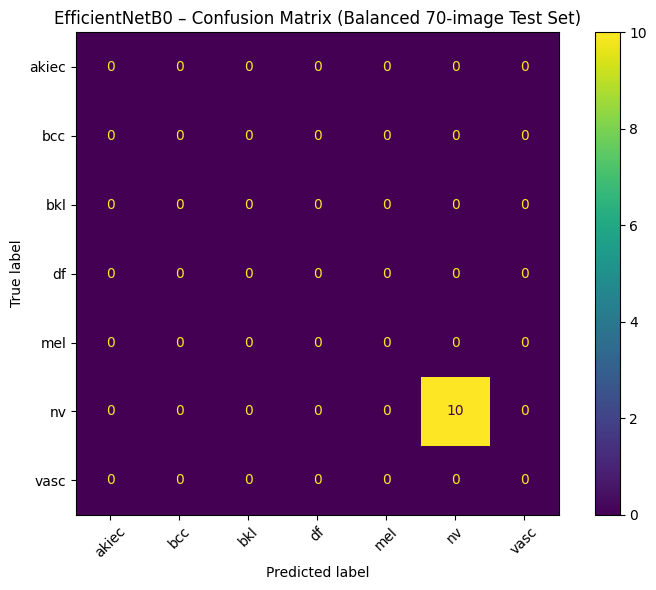

In [ ]:
import tensorflow as tf
import autokeras as ak
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict
import os

# ------------------ Load Fresh Validation Dataset ------------------

data_dir = "/content/drive/MyDrive/HAM10000/images"
img_size = (224, 224)

raw_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=1,
    shuffle=False
)

class_names = raw_test_ds.class_names
num_classes = len(class_names)

# ------------------ Extract 10 Images per Class (Balanced Subset) ------------------

balanced_x = []
balanced_y = []
seen_counts = defaultdict(int)

for image, label in raw_test_ds.unbatch():
    label_id = int(label.numpy())
    if seen_counts[label_id] < 10:
        balanced_x.append(image.numpy())
        balanced_y.append(label_id)
        seen_counts[label_id] += 1
    if all(count >= 10 for count in seen_counts.values()):
        break

balanced_x = np.array(balanced_x)
balanced_y = np.array(balanced_y)

print(f"✅ Created balanced test set with shape: {balanced_x.shape}")

# ------------------ Define Model Paths ------------------

model_paths = {
    "AutoKeras": "/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras",
    "AlexNet": "/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras",
    "ResNet50": "/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras",
    "EfficientNetB0": "/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras",
}

# ------------------ Create Output Directory ------------------

output_dir = "/content/drive/MyDrive/HAM10000/final_balanced_confusion_matrices"
os.makedirs(output_dir, exist_ok=True)

# ------------------ Evaluate All Models ------------------

for model_name, model_path in model_paths.items():
    try:
        print(f"\n🔹 Loading {model_name}...")
        model = tf.keras.models.load_model(
            model_path,
            custom_objects=ak.CUSTOM_OBJECTS if model_name == "AutoKeras" else None
        )

        # Resize input for AutoKeras
        x_input = tf.image.resize(balanced_x, [32, 32]) if model_name == "AutoKeras" else balanced_x

        # Predict
        preds = model.predict(x_input)
        y_pred = np.argmax(preds, axis=1)
        y_true = balanced_y

        # Report
        print(f"\n📊 Classification Report – {model_name}")
        print(classification_report(
            y_true, y_pred,
            labels=list(range(num_classes)),
            target_names=class_names,
            zero_division=0
        ))

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(ax=ax, cmap='viridis', xticks_rotation=45)
        plt.title(f"{model_name} – Confusion Matrix (Balanced 70-image Test Set)")
        plt.tight_layout()
        plt.savefig(f"{output_dir}/{model_name}_confusion_matrix_balanced.png")
        plt.show()

    except Exception as e:
        print(f"❌ Error with {model_name}: {e}")


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import autokeras as ak

# === SETTINGS ===
DATA_DIR = "/content/drive/MyDrive/HAM10000/images"
CHECKPOINT_DIR = "/content/drive/MyDrive/HAM10000/checkpoints"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
AUTO_IMG_SIZE = (32, 32)
AUTOKERAS_EPOCHS = 5
CNN_EPOCHS = 10
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# === LOAD DATASET ===
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names

# === PREFETCHING ===
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

# === DATA AUGMENTATION ===
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# === CLASS WEIGHTS ===
y_train = np.concatenate([y.numpy() for _, y in train_ds], axis=0)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# === CALLBACKS ===
def get_callbacks(model_name):
    return [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(
            filepath=os.path.join(CHECKPOINT_DIR, f"{model_name}.keras"),
            save_best_only=True,
            monitor="val_loss",
            mode="min",
            verbose=1
        )
    ]

# === MODEL TRAINING WRAPPER ===
def train_model(model, name, train_ds, val_ds, class_weights, epochs):
    print(f"\n🚀 Training: {name}")
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=get_callbacks(name),
        verbose=2
    )
    return model

# === LOAD MODELS ===
alexnet = tf.keras.models.load_model("/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras")
resnet = tf.keras.models.load_model("/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras")
efficientnet = tf.keras.models.load_model("/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras")

# === AUTOKERAS ===
ak_model_path = "/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras"
ak_model = tf.keras.models.load_model(ak_model_path, custom_objects=ak.CUSTOM_OBJECTS)

# === MODEL LIST ===
models = {
    "AutoKeras": (ak_model, AUTO_IMG_SIZE),
    "AlexNet": (alexnet, IMG_SIZE),
    "ResNet50": (resnet, IMG_SIZE),
    "EfficientNetB0": (efficientnet, IMG_SIZE)
}

# === EVALUATION FUNCTION ===
def evaluate_model(model, name, img_size):
    # Prepare test dataset again to avoid shuffling issues
    test_ds = image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=img_size,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    x_test, y_true = [], []
    for images, labels in test_ds:
        x_test.extend(images.numpy())
        y_true.extend(labels.numpy())
    x_test = np.array(x_test)
    y_true = np.array(y_true)

    # Predict
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Classification Report
    print(f"\n📊 Classification Report for {name}")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Show Sample Predictions
    print(f"\n🖼️ Visualizing Predictions for {name}")
    indices = random.sample(range(len(x_test)), 5)
    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(indices):
        img = x_test[idx].astype("uint8")
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{name}\nTrue: {true_label}\nPred: {pred_label}",
                  color='green' if true_label == pred_label else 'red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# === RUN EVALUATIONS ===
for name, (model, size) in models.items():
    evaluate_model(model, name, size)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image

# Set paths
dataset_dir = '/content/drive/MyDrive/HAM10000'
metadata_path = os.path.join(dataset_dir, 'HAM10000_metadata.csv')
images_dir = os.path.join(dataset_dir, 'HAM10000_images')
balanced_dir = os.path.join(dataset_dir, 'balanced_data')

# Load metadata
df = pd.read_csv(metadata_path)

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])

# Create balanced dataset
if os.path.exists(balanced_dir):
    shutil.rmtree(balanced_dir)
os.makedirs(balanced_dir, exist_ok=True)

min_count = df['label'].value_counts().min()
balanced_df = df.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

for label in balanced_df['label'].unique():
    os.makedirs(os.path.join(balanced_dir, str(label)), exist_ok=True)

for _, row in balanced_df.iterrows():
    src = os.path.join(images_dir, row['image_id'] + '.jpg')
    dst = os.path.join(balanced_dir, str(row['label']), row['image_id'] + '.jpg')
    shutil.copyfile(src, dst)

# Split data
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for label in os.listdir(balanced_dir):
    images = os.listdir(os.path.join(balanced_dir, label))
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    for img in train_imgs:
        shutil.copyfile(os.path.join(balanced_dir, label, img), os.path.join(train_dir, label, img))
    for img in val_imgs:
        shutil.copyfile(os.path.join(balanced_dir, label, img), os.path.join(val_dir, label, img))

# Data generators
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(balanced_df['label']),
    y=balanced_df['label']
)
class_weights = dict(enumerate(class_weights))

# Define model architectures
def build_model(base_model):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    return model

# Load base models
base_models = {
    'EfficientNetB0': EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3)),
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
}

# Training parameters
epochs = 10
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train and evaluate models
for name, base in base_models.items():
    print(f"\n🔹 Training {name}...")
    base.trainable = False
    model = build_model(base)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])





FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/HAM10000/HAM10000_metadata.csv'

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
import autokeras as ak
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Paths to models
model_paths = {
    "AutoKeras": "/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras",
    "AlexNet": "/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras",
    "ResNet50": "/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras",
    "EfficientNetB0": "/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras",
}

# Dataset path
data_dir = "/content/drive/MyDrive/HAM10000/images"
img_size = (224, 224)
batch_size = 32

# Load dataset
test_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Get class names
class_names = test_ds.class_names
class_to_index = {name: i for i, name in enumerate(class_names)}
index_to_class = {i: name for name, i in class_to_index.items()}

# Preload all test data (images and labels)
x_test = []
y_test = []

for images, labels in test_ds:
    x_test.extend(images.numpy())
    y_test.extend(labels.numpy())

x_test = np.array(x_test)
y_test = np.array(y_test)
y_test_names = [index_to_class[i] for i in y_test]

# Resize for AutoKeras (assuming AutoKeras model expects 32x32 input)
x_test_autokeras = tf.image.resize(x_test, [32, 32])

# Prepare results
accuracy_results = {}
results_df = pd.DataFrame({"True Label": y_test_names})

# Load the AutoKeras model
ak_model = ak.load_model("/content/drive/MyDrive/HAM10000/skin_lesion_fine_tuned_model_checkpoint.keras")

# Predict with each model
for model_name, model_path in model_paths.items():
    print(f"\n🔹 Loading {model_name}...")
    if model_name == "AutoKeras":
        model = ak_model
    else:
        model = tf.keras.models.load_model(model_path)

    print(f"🚀 Evaluating {model_name}...")

    if model_name == "AutoKeras":
        preds = model.predict(x_test_autokeras)
    else:
        preds = model.predict(x_test)

    pred_labels = np.argmax(preds, axis=1)
    pred_names = [index_to_class[i] for i in pred_labels]

    # Accuracy
    acc = np.mean(pred_labels == y_test)
    accuracy_results[model_name] = acc

    # Add predictions to DataFrame
    results_df[model_name + " Prediction"] = pred_names

    # Confusion Matrix
    cm = confusion_matrix(y_test, pred_labels, labels=list(range(len(class_names))))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.tight_layout()

    # Save confusion matrix plot
    confusion_matrix_save_path = f"/content/drive/MyDrive/HAM10000/confusion_matrices/{model_name}_confusion_matrix.png"
    plt.savefig(confusion_matrix_save_path)
    plt.show()

    # Classification report
    report = classification_report(
        y_test,
        pred_labels,
        labels=list(range(len(class_names))),
        target_names=class_names,
        zero_division=0  # avoids divide-by-zero errors if any class isn't predicted
    )
    print(f"\n🔹 {model_name} - Classification Report 🔹\n{report}")

# Show model-wise accuracy
print("\n🔹 Model Accuracy on Full Test Set 🔹")
for name, acc in sorted(accuracy_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {acc:.4f}")

# Best model
best_model = max(accuracy_results, key=accuracy_results.get)
print(f"\n🏆 Best Model: {best_model} with {accuracy_results[best_model]:.4f} accuracy")

# Preview predictions
print("\n📊 Sample Comparison Table:")
print(results_df.head(10))

# Save results
results_df.to_csv("/content/drive/MyDrive/HAM10000/final_model_predictions_comparison.csv", index=False)
print("✅ Saved predictions comparison to Drive!")


Found 10015 files belonging to 7 classes.
Using 2003 files for validation.


KeyboardInterrupt: 

In [ ]:
!pip install autokeras --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.4 MB/s eta 0:00:00


In [ ]:
import autokeras as ak
print(ak.__version__)


2.0.0


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import autokeras as ak

# Paths
data_dir = "/content/drive/MyDrive/HAM10000/images"
checkpoint_dir = "/content/drive/MyDrive/HAM10000/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Parameters
img_size = (224, 224)
batch_size = 32
AUTOKERAS_EPOCHS = 5
CNN_EPOCHS = 10

# Load datasets
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Class Weights
y_train = np.concatenate([y.numpy() for _, y in train_ds], axis=0)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3)
])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def prepare_and_train_model(model_name, model, train_ds, val_ds, class_weights, epochs):
    print(f"\n🔧 Training {model_name}")
    checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_checkpoint.keras")

    if os.path.exists(checkpoint_path):
        print(f"🔁 Resuming {model_name} from checkpoint...")
        model = tf.keras.models.load_model(checkpoint_path)
    else:
        print(f"🆕 Starting fresh {model_name}")

    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        verbose=1
    )

    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=[early_stopping, checkpoint],
        verbose=2
    )
    print(f"✅ {model_name} training complete.\n")

# --- AutoKeras Model ---
autokeras_path = os.path.join(checkpoint_dir, "AutoKeras_checkpoint")
if os.path.exists(autokeras_path):
    print("🔁 Loading AutoKeras model...")
    ak_model = ak.load_model(autokeras_path)
else:
    print("⚙️ Training new AutoKeras model...")
    ak_model = ak.ImageClassifier(overwrite=True, max_trials=1)
    ak_model.fit(train_ds, epochs=AUTOKERAS_EPOCHS)
    ak_model.export_model().save(autokeras_path)

# --- AlexNet ---
alexnet_model_path = "/content/drive/MyDrive/HAM10000/alexnet_finetuned.keras"
alexnet = tf.keras.models.load_model(alexnet_model_path)
prepare_and_train_model("AlexNet", alexnet, train_ds, val_ds, class_weight_dict, CNN_EPOCHS)

# --- ResNet50 ---
resnet_model_path = "/content/drive/MyDrive/HAM10000/resnet50_finetuned.keras"
resnet = tf.keras.models.load_model(resnet_model_path)
prepare_and_train_model("ResNet50", resnet, train_ds, val_ds, class_weight_dict, CNN_EPOCHS)

# --- EfficientNetB0 ---
efficientnet_path = "/content/drive/MyDrive/HAM10000/efficientnet_finetuned.keras"
efficientnet = tf.keras.models.load_model(efficientnet_path)
prepare_and_train_model("EfficientNetB0", efficientnet, train_ds, val_ds, class_weight_dict, CNN_EPOCHS)


Trial 1 Complete [00h 33m 19s]
val_loss: 1.1662788391113281

Best val_loss So Far: 1.1662788391113281
Total elapsed time: 00h 33m 19s
Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.6010 - loss: 3.2995
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.6527 - loss: 1.2620
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.6548 - loss: 1.2607
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.6572 - loss: 1.2266
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.6574 - loss: 1.2015


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/drive/MyDrive/HAM10000/checkpoints/AutoKeras_checkpoint.